In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc
    
# seed the pseudorandom number generator
from random import seed
from random import random
# seed random number generator
seed(1)

# seed the pseudorandom number generator
from numpy.random import seed as seed_np
from numpy.random import rand as rand_np
# seed random number generator
seed_np(1)

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/JohnsHopkins.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = ld_coord[idx[i],1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_JH', ref_nodes) 
            np.save('results/info_ref_nodes_JH', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 1 Feature value  217.0  gap  [0.76972008]  volume:  10696.0  size: 200 conductance:  0.262341062079282
Reached
Number of feature 2 Feature value  2008.0  gap  [0.86957805]  volume:  82875.0  size: 912 conductance:  0.3928446455505279
Reached
Number of feature 2 Feature value  2009.0  gap  [0.83656915]  volume:  32454.0  size: 886 conductance:  0.19757194798792135


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [6]:
ref_nodes = np.load('results/ref_nodes_JH.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_JH.npy') 

## Visualize the ground truth clusters

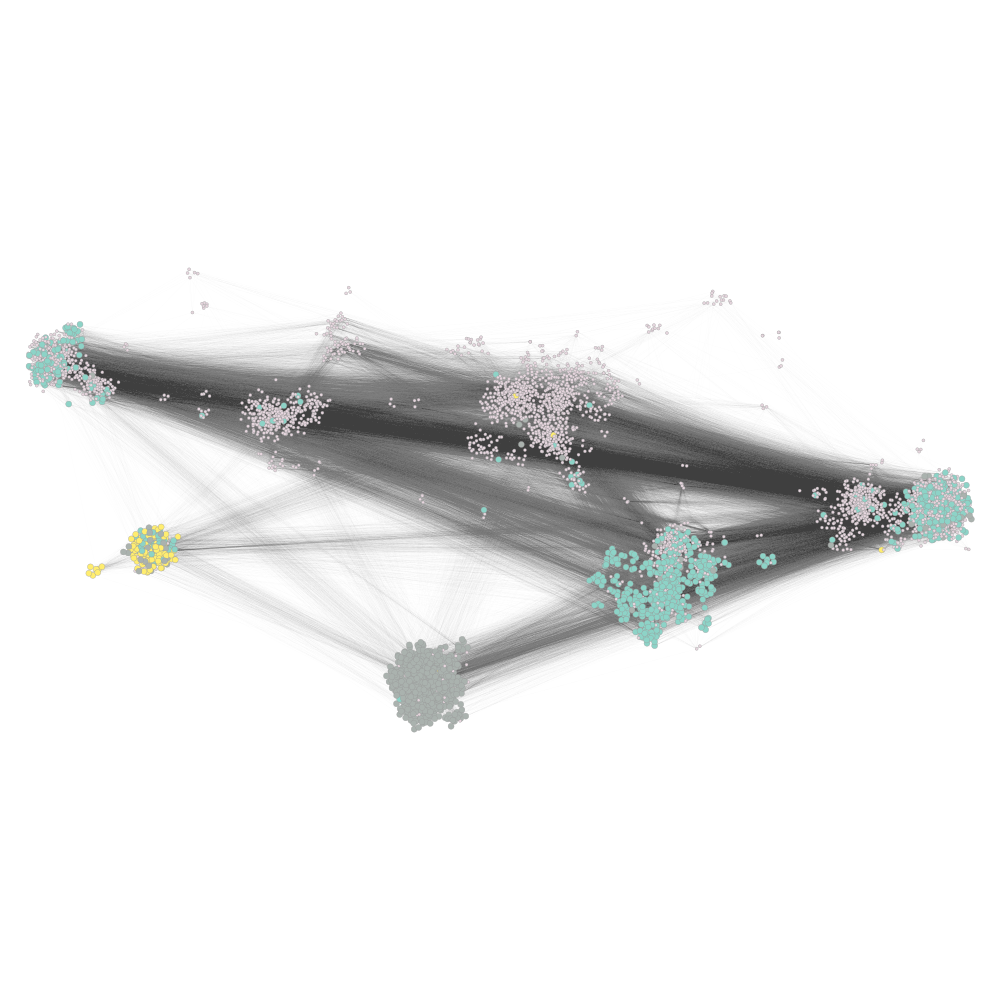

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae7f9e8, at 0x10b5856a0>

In [7]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [8]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            rho = 0.2/sum(g.d[rr])

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=rho,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_JH', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_JH', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_JH', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_JH', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_JH', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_JH', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_JH', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_JH', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_JH', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_JH', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_JH', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_JH', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_JH', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_JH', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_JH', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_JH', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_JH', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_JH', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_JH', cuts_acl_ALL) 
    
    np.save('results/nodes_JH', nodes)

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.24259622329996905 f1score:  0.8365134644626477 precision:  0.8798885563925292 recall:  0.7972139117427075
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18402590393955748 f1score:  0.9413220867332904 precision:  0.9234574563770462 recall:  0.9598915482423336
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.20800790017057186 f1score:  0.9089993130295397 precision:  0.8909237813089146 recall:  0.9278234854151085
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.27177334732423925 f1score:  0.8598657136668832 precision:  0.8011138913552345 recall:  0.9279169783096485
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.2334189742125797 f1score:  0.8689513541265562 precision:  0.8010570324209197 recall:  0.9494203440538519
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduc

outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18290221977618787 f1score:  0.9404574497638671 precision:  0.9315721885892497 recall:  0.949513836948392
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.4129718967761697 f1score:  0.7238897074300148 precision:  0.6583965081552952 recall:  0.8038519072550486
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.20014044943820225 f1score:  0.9195943498732343 precision:  0.891502808988764 recall:  0.949513836948392
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance:  0.38033565790482027 f1score:  0.776079174563066 precision:  0.7061077477201319 recall:  0.8614435302916978
outer: 0 number of node:  2854  completed:  0.51  degree:  32.0
conductance:  0.20646555774833192 f1score:  0.8832544406430145 precision:  0.8855370735833098 recall:  0.880983545250561
outer: 0 number of node:  1072  completed:  0.52  degree:  21.0
conductance:

outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.21314477566385187 f1score:  0.8754893578724745 precision:  0.8439316387611694 recall:  0.9094988780852655
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
conductance:  0.20571710202069984 f1score:  0.8920877117220863 precision:  0.9163134549038936 recall:  0.8691099476439791
outer: 0 number of node:  1718  completed:  0.98  degree:  39.0
conductance:  0.20887281035795888 f1score:  0.8964150943396226 precision:  0.9046077684691546 recall:  0.8883694839192221
outer: 0 number of node:  2530  completed:  0.99  degree:  41.0
conductance:  0.19929732103645148 f1score:  0.9307549476925865 precision:  0.9025911286780852 recall:  0.9607329842931938
456
outer: 1 number of node:  2326  completed:  0.0  degree:  34.0
conductance:  0.18413954324761733 f1score:  0.04931748128577719 precision:  0.22430636967565457 recall:  0.027704374057315233
outer: 1 number of node:  3947  completed:  0.00219298245614035

outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.39285678744514213 f1score:  0.5735430459964441 precision:  0.5232816185178182 recall:  0.6344856711915535
outer: 1 number of node:  1027  completed:  0.08552631578947369  degree:  84.0
conductance:  0.4831878771558319 f1score:  0.6969472328221084 precision:  0.7019719206335606 recall:  0.6919939668174963
outer: 1 number of node:  4727  completed:  0.08771929824561403  degree:  53.0
conductance:  0.4902949830625819 f1score:  0.6819328167268153 precision:  0.690317236604604 recall:  0.6737496229260935
outer: 1 number of node:  423  completed:  0.08991228070175439  degree:  134.0
conductance:  0.4547817827325901 f1score:  0.7422077882212822 precision:  0.7554866769984502 recall:  0.7293876319758673
outer: 1 number of node:  751  completed:  0.09210526315789473  degree:  60.0
conductance:  0.44752921497107545 f1score:  0.7639040962115518 precision:  0.7496573194247613 recall:  0.7787028657616893

outer: 1 number of node:  483  completed:  0.17982456140350878  degree:  85.0
conductance:  0.556253256190189 f1score:  0.5659091346678391 precision:  0.6044585812607969 recall:  0.5319819004524887
outer: 1 number of node:  725  completed:  0.18201754385964913  degree:  338.0
conductance:  0.5053880056302928 f1score:  0.6534630106930741 precision:  0.6391420725938575 recall:  0.6684404223227752
outer: 1 number of node:  4933  completed:  0.18421052631578946  degree:  114.0
conductance:  0.4191483345586156 f1score:  0.8281627649016288 precision:  0.8022168184131652 recall:  0.8558431372549019
outer: 1 number of node:  5076  completed:  0.18640350877192982  degree:  144.0
conductance:  0.5138306593277902 f1score:  0.6035242028942441 precision:  0.5946363742827029 recall:  0.6126817496229261
outer: 1 number of node:  3222  completed:  0.18859649122807018  degree:  1.0
conductance:  0.5878185934419046 f1score:  0.5953925621335735 precision:  0.7481377346089243 recall:  0.49444343891402714


outer: 1 number of node:  3879  completed:  0.27631578947368424  degree:  232.0
conductance:  0.5533157150759019 f1score:  0.5029044632527554 precision:  0.5076024829451171 recall:  0.4982926093514329
outer: 1 number of node:  1044  completed:  0.27850877192982454  degree:  127.0
conductance:  0.46806700935616286 f1score:  0.7159233649190844 precision:  0.7236542041098085 recall:  0.7083559577677224
outer: 1 number of node:  4575  completed:  0.2807017543859649  degree:  45.0
conductance:  0.20078111130836143 f1score:  0.05030979460193516 precision:  0.20832967226078553 recall:  0.028609351432880844
outer: 1 number of node:  738  completed:  0.28289473684210525  degree:  111.0
conductance:  0.47258517977235853 f1score:  0.7154557011539213 precision:  0.7249105163423787 recall:  0.7062443438914027
outer: 1 number of node:  4573  completed:  0.2850877192982456  degree:  214.0
conductance:  0.42851019188033707 f1score:  0.6618082600685619 precision:  0.640255389231689 recall:  0.684862745

outer: 1 number of node:  1391  completed:  0.3684210526315789  degree:  40.0
conductance:  0.6072151947108954 f1score:  0.36487457862383504 precision:  0.37503980841008394 recall:  0.35524585218702864
outer: 1 number of node:  4165  completed:  0.3706140350877193  degree:  228.0
conductance:  0.5535066208925944 f1score:  0.48776720284610936 precision:  0.49169936243256496 recall:  0.4838974358974359
outer: 1 number of node:  2000  completed:  0.37280701754385964  degree:  189.0
conductance:  0.360829657885326 f1score:  0.42797600562266064 precision:  0.3901537727977113 recall:  0.4739185520361991
outer: 1 number of node:  1068  completed:  0.375  degree:  42.0
conductance:  0.5226906303687062 f1score:  0.30983001671449745 precision:  0.3245804149596934 recall:  0.29636199095022625
outer: 1 number of node:  2691  completed:  0.37719298245614036  degree:  24.0
conductance:  0.5397734077462933 f1score:  0.4598222067282552 precision:  0.45810678100074254 recall:  0.46155052790346907
outer

outer: 1 number of node:  5124  completed:  0.4583333333333333  degree:  18.0
conductance:  0.5208958987643566 f1score:  0.6176690160301439 precision:  0.6022099447513812 recall:  0.6339426847662142
outer: 1 number of node:  861  completed:  0.4605263157894737  degree:  121.0
conductance:  0.45417435140784457 f1score:  0.7364940166255596 precision:  0.7434894872740686 recall:  0.7296289592760181
outer: 1 number of node:  3310  completed:  0.46271929824561403  degree:  23.0
conductance:  0.524482260394927 f1score:  0.5051443480233679 precision:  0.4765987049820731 recall:  0.5373273001508295
outer: 1 number of node:  2646  completed:  0.4649122807017544  degree:  88.0
conductance:  0.482603954719696 f1score:  0.5454979282089484 precision:  0.5268500511483076 recall:  0.5655143288084464
outer: 1 number of node:  1393  completed:  0.46710526315789475  degree:  53.0
conductance:  0.5749624744412533 f1score:  0.5870650330777865 precision:  0.5810492973560732 recall:  0.5932066365007541
oute

outer: 1 number of node:  4926  completed:  0.5570175438596491  degree:  80.0
conductance:  0.4705225750603672 f1score:  0.49335856706763304 precision:  0.4795320971342658 recall:  0.5080060331825038
outer: 1 number of node:  3418  completed:  0.5592105263157895  degree:  26.0
conductance:  0.48694697656660146 f1score:  0.3968875797152747 precision:  0.39466902114255714 recall:  0.39913122171945703
outer: 1 number of node:  2148  completed:  0.5614035087719298  degree:  209.0
conductance:  0.46837415396601256 f1score:  0.6792507711046339 precision:  0.6822564152505235 recall:  0.6762714932126697
outer: 1 number of node:  2479  completed:  0.5635964912280702  degree:  99.0
conductance:  0.4973264534849708 f1score:  0.5606681636192988 precision:  0.5521663332046287 recall:  0.5694358974358974
outer: 1 number of node:  1805  completed:  0.5657894736842105  degree:  91.0
conductance:  0.49759910273036345 f1score:  0.7228672507538524 precision:  0.7113899501127429 recall:  0.734720965309200

outer: 1 number of node:  336  completed:  0.6491228070175439  degree:  152.0
conductance:  0.3955585841985008 f1score:  0.48337101657150056 precision:  0.44240790475808717 recall:  0.5326938159879336
outer: 1 number of node:  930  completed:  0.6513157894736842  degree:  93.0
conductance:  0.43292881724325305 f1score:  0.42924738970366344 precision:  0.4294028859506128 recall:  0.4290920060331825
outer: 1 number of node:  288  completed:  0.6535087719298246  degree:  70.0
conductance:  0.5007264780580001 f1score:  0.6815137587297797 precision:  0.6743488275943536 recall:  0.6888325791855203
outer: 1 number of node:  169  completed:  0.6557017543859649  degree:  104.0
conductance:  0.479212550401518 f1score:  0.6361907428798114 precision:  0.6158416065236788 recall:  0.6579306184012066
outer: 1 number of node:  3260  completed:  0.6578947368421053  degree:  118.0
conductance:  0.6081043342269884 f1score:  0.5214025412483575 precision:  0.5623882931188561 recall:  0.4859849170437406
out

outer: 1 number of node:  3024  completed:  0.743421052631579  degree:  33.0
conductance:  0.5690433370075999 f1score:  0.35163847154856265 precision:  0.34488600104426526 recall:  0.3586606334841629
outer: 1 number of node:  389  completed:  0.7456140350877193  degree:  144.0
conductance:  0.4483027701911822 f1score:  0.7453058006012517 precision:  0.7613557700779077 recall:  0.729918552036199
outer: 1 number of node:  3537  completed:  0.7478070175438597  degree:  117.0
conductance:  0.48152723446114426 f1score:  0.6654805315294684 precision:  0.6481595863930638 recall:  0.6837526395173454
outer: 1 number of node:  4755  completed:  0.75  degree:  48.0
conductance:  0.6187520988649339 f1score:  0.5193618103229088 precision:  0.5487675465108469 recall:  0.492947209653092
outer: 1 number of node:  3049  completed:  0.7521929824561403  degree:  86.0
conductance:  0.3958495385708661 f1score:  0.500181810403833 precision:  0.44912755802675425 recall:  0.5643318250377074
outer: 1 number of

outer: 1 number of node:  2111  completed:  0.8421052631578947  degree:  84.0
conductance:  0.508899854862119 f1score:  0.5556213017751479 precision:  0.5451378809869376 recall:  0.5665158371040724
outer: 1 number of node:  4129  completed:  0.8442982456140351  degree:  74.0
conductance:  0.526321905868681 f1score:  0.14542276198362314 precision:  0.3061398411776099 recall:  0.0953604826546003
outer: 1 number of node:  53  completed:  0.8464912280701754  degree:  36.0
conductance:  0.23432398493093345 f1score:  0.06014973896284059 precision:  0.24575977847005884 recall:  0.0342684766214178
outer: 1 number of node:  1342  completed:  0.8486842105263158  degree:  152.0
conductance:  0.3679839518555667 f1score:  0.4524825414213337 precision:  0.41430290872617853 recall:  0.4984132730015083
outer: 1 number of node:  2123  completed:  0.8508771929824561  degree:  28.0
conductance:  0.4973489377634455 f1score:  0.6620189289680815 precision:  0.6623307607763567 recall:  0.6617073906485671
out

outer: 1 number of node:  1871  completed:  0.9407894736842105  degree:  32.0
conductance:  0.5060323397267772 f1score:  0.6736276814661516 precision:  0.6551189363012293 recall:  0.6932126696832579
outer: 1 number of node:  2480  completed:  0.9429824561403509  degree:  238.0
conductance:  0.5624182964238102 f1score:  0.46725283509017335 precision:  0.4842287829564722 recall:  0.4514268476621418
outer: 1 number of node:  3094  completed:  0.9451754385964912  degree:  54.0
conductance:  0.5285190036480942 f1score:  0.5300595713600985 precision:  0.5027983155980384 recall:  0.560446455505279
outer: 1 number of node:  4793  completed:  0.9473684210526315  degree:  138.0
conductance:  0.5526757127610916 f1score:  0.21569983573960405 precision:  0.3803933526452203 recall:  0.15052790346907993
outer: 1 number of node:  2920  completed:  0.9495614035087719  degree:  230.0
conductance:  0.46611513271285765 f1score:  0.6363202966363555 precision:  0.6211306446053085 recall:  0.6522714932126696

outer: 2 number of node:  3150  completed:  0.03837471783295711  degree:  33.0
conductance:  0.2077303212142605 f1score:  0.929240030097818 precision:  0.9081656665490058 recall:  0.9513157083872558
outer: 2 number of node:  4149  completed:  0.040632054176072234  degree:  11.0
conductance:  0.1975519755197552 f1score:  0.08399216319004264 precision:  0.166681913823072 recall:  0.0561409995686202
outer: 2 number of node:  4086  completed:  0.04288939051918736  degree:  115.0
conductance:  0.18985014250252827 f1score:  0.9459015134055465 precision:  0.9433360914467838 recall:  0.9484809268503112
outer: 2 number of node:  3285  completed:  0.045146726862302484  degree:  23.0
conductance:  0.18961023216342365 f1score:  0.9416330521941082 precision:  0.9339273807358913 recall:  0.9494669378196833
outer: 2 number of node:  1918  completed:  0.04740406320541761  degree:  3.0
conductance:  0.35722081505735054 f1score:  0.7721286181571314 precision:  0.6440765223121435 recall:  0.9637332840327

outer: 2 number of node:  3075  completed:  0.13544018058690746  degree:  10.0
conductance:  0.29484029484029484 f1score:  0.854460231434012 precision:  0.8143567120839849 recall:  0.8987181857398163
outer: 2 number of node:  3973  completed:  0.13769751693002258  degree:  9.0
conductance:  0.38823752338994294 f1score:  0.7656047031724988 precision:  0.6770648286316587 recall:  0.8807851112343624
outer: 2 number of node:  3982  completed:  0.1399548532731377  degree:  162.0
conductance:  0.1972551822730522 f1score:  0.9408118168740452 precision:  0.9069049320943531 recall:  0.9773525605472361
outer: 2 number of node:  4423  completed:  0.14221218961625282  degree:  42.0
conductance:  0.2133782292521434 f1score:  0.9213953831403495 precision:  0.8837610707110721 recall:  0.9623775189498983
outer: 2 number of node:  3657  completed:  0.14446952595936793  degree:  4.0
conductance:  0.55179788798289 f1score:  0.5880527540729248 precision:  0.5066167624649112 recall:  0.7006840451100018
out

outer: 2 number of node:  1229  completed:  0.23024830699774265  degree:  121.0
conductance:  0.21752506523829143 f1score:  0.9102368608315543 precision:  0.8608432907567641 recall:  0.9656436802859432
outer: 2 number of node:  3641  completed:  0.2325056433408578  degree:  110.0
conductance:  0.18223752998339382 f1score:  0.9487471526195901 precision:  0.9478135186665847 recall:  0.9496826277192334
outer: 2 number of node:  2063  completed:  0.23476297968397292  degree:  2.0
conductance:  0.1965717783899602 f1score:  0.9308396290154168 precision:  0.9277624732170187 recall:  0.9339372650520738
outer: 2 number of node:  137  completed:  0.23702031602708803  degree:  30.0
conductance:  0.30062878502506446 f1score:  0.8407376987978795 precision:  0.8156819564776449 recall:  0.8673815246194614
outer: 2 number of node:  1109  completed:  0.23927765237020315  degree:  6.0
conductance:  0.5323184427252309 f1score:  0.5703315565995121 precision:  0.4501408249848479 recall:  0.7780859062057065

outer: 2 number of node:  5132  completed:  0.327313769751693  degree:  26.0
conductance:  0.21055911176570555 f1score:  0.9285714285714286 precision:  0.8910666742196793 recall:  0.9693720342638812
outer: 2 number of node:  3312  completed:  0.3295711060948081  degree:  21.0
conductance:  0.21825825825825826 f1score:  0.9118228548833531 precision:  0.9002402402402402 recall:  0.9237074012448389
outer: 2 number of node:  4161  completed:  0.33182844243792325  degree:  2.0
conductance:  0.42409142857142856 f1score:  0.6693086977061572 precision:  0.5829028571428572 recall:  0.7857891169039256
outer: 2 number of node:  533  completed:  0.3340857787810384  degree:  1.0
conductance:  0.1978397169284251 f1score:  0.9369124195942603 precision:  0.9403439071326588 recall:  0.9335058852529734
outer: 2 number of node:  4177  completed:  0.3363431151241535  degree:  112.0
conductance:  0.22572194468136955 f1score:  0.9106032290677369 precision:  0.9054161082003168 recall:  0.9158501263326555
out

outer: 2 number of node:  3200  completed:  0.4221218961625282  degree:  220.0
conductance:  0.23648006946517244 f1score:  0.9064885220829064 precision:  0.8523865085610398 recall:  0.967923830652616
outer: 2 number of node:  1492  completed:  0.42437923250564336  degree:  17.0
conductance:  0.21802367032653644 f1score:  0.921281417082599 precision:  0.8869813204049622 recall:  0.9583410365440316
outer: 2 number of node:  3535  completed:  0.42663656884875845  degree:  29.0
conductance:  0.17191312835529526 f1score:  0.9606364388853121 precision:  0.9558016105417276 recall:  0.9655204289147716
outer: 2 number of node:  929  completed:  0.4288939051918736  degree:  10.0
conductance:  0.18456258724988367 f1score:  0.9521529668751308 precision:  0.9254304327594229 recall:  0.9804646576693166
outer: 2 number of node:  3252  completed:  0.43115124153498874  degree:  155.0
conductance:  0.2924383319007059 f1score:  0.8678946996965204 precision:  0.8007866427027168 recall:  0.947279225981389


outer: 2 number of node:  3340  completed:  0.5169300225733634  degree:  9.0
conductance:  0.22548613984278032 f1score:  0.8967201565557731 precision:  0.911460488208523 recall:  0.8824490047451778
outer: 2 number of node:  1531  completed:  0.5191873589164786  degree:  29.0
conductance:  0.1795787434935238 f1score:  0.9513572933524688 precision:  0.9428640600411572 recall:  0.9600049300548469
outer: 2 number of node:  2351  completed:  0.5214446952595937  degree:  73.0
conductance:  0.18118725988350476 f1score:  0.9471960451104587 precision:  0.9498079068038171 recall:  0.9445985086584088
outer: 2 number of node:  3891  completed:  0.5237020316027088  degree:  10.0
conductance:  0.2945017783219637 f1score:  0.8437593624543112 precision:  0.821030843682584 recall:  0.8677820915757688
outer: 2 number of node:  4214  completed:  0.5259593679458239  degree:  1.0
conductance:  0.20768476528986396 f1score:  0.9243201720694423 precision:  0.9217428606446868 recall:  0.9269119368952979
outer:

outer: 2 number of node:  2485  completed:  0.6117381489841986  degree:  58.0
conductance:  0.21534243273373707 f1score:  0.9149490425483296 precision:  0.9048178613396005 recall:  0.9253096690700684
outer: 2 number of node:  1374  completed:  0.6139954853273137  degree:  11.0
conductance:  0.23624653367921997 f1score:  0.7606064532849552 precision:  0.6563198854995974 recall:  0.904295310285327
outer: 2 number of node:  2715  completed:  0.6162528216704289  degree:  110.0
conductance:  0.18126091977849507 f1score:  0.9571598991287015 precision:  0.9385234978826734 recall:  0.9765514266346214
outer: 2 number of node:  2377  completed:  0.618510158013544  degree:  17.0
conductance:  0.21206997084548104 f1score:  0.9213530275339306 precision:  0.8965597667638484 recall:  0.9475565415665249
outer: 2 number of node:  4171  completed:  0.6207674943566591  degree:  20.0
conductance:  0.45207857469164003 f1score:  0.6666316866490019 precision:  0.5804020100502513 recall:  0.782954335366981
ou

outer: 2 number of node:  1040  completed:  0.708803611738149  degree:  9.0
conductance:  0.23459320197909653 f1score:  0.8958880665355572 precision:  0.8735544690692977 recall:  0.9193936032538362
outer: 2 number of node:  989  completed:  0.7110609480812641  degree:  163.0
conductance:  0.24560256883862353 f1score:  0.8965925049892822 precision:  0.861726009491063 recall:  0.9343994576939668
outer: 2 number of node:  4797  completed:  0.7133182844243793  degree:  77.0
conductance:  0.19178926966787066 f1score:  0.9491632459741081 precision:  0.9268786891022818 recall:  0.9725457570715474
outer: 2 number of node:  2697  completed:  0.7155756207674944  degree:  50.0
conductance:  0.36747670466369164 f1score:  0.7417143310040553 precision:  0.6491479571782006 recall:  0.8650705614099957
outer: 2 number of node:  908  completed:  0.7178329571106095  degree:  7.0
conductance:  0.445188858408947 f1score:  0.7335076599494074 precision:  0.6807079552648237 recall:  0.7951870339557527
outer: 

outer: 2 number of node:  3663  completed:  0.8058690744920993  degree:  44.0
conductance:  0.1775610052572401 f1score:  0.9531371919034287 precision:  0.9465767162002006 recall:  0.9597892401552968
outer: 2 number of node:  361  completed:  0.8081264108352144  degree:  20.0
conductance:  0.20943952802359883 f1score:  0.9193312625616663 precision:  0.9087050749503341 recall:  0.9302089110741357
outer: 2 number of node:  4082  completed:  0.8103837471783296  degree:  3.0
conductance:  0.1951935914552737 f1score:  0.9444520019951934 precision:  0.9269247886070316 recall:  0.9626548345350342
outer: 2 number of node:  1747  completed:  0.8126410835214447  degree:  1.0
conductance:  0.22823707940584237 f1score:  0.9189610467469013 precision:  0.8946508302448419 recall:  0.9446293215012017
outer: 2 number of node:  47  completed:  0.8148984198645598  degree:  27.0
conductance:  0.20438314973834099 f1score:  0.9340254471144523 precision:  0.9052245063174025 recall:  0.9647192950021569
outer: 

outer: 2 number of node:  3668  completed:  0.9006772009029346  degree:  19.0
conductance:  0.41024159977692354 f1score:  0.6359710141420984 precision:  0.5235325751389248 recall:  0.8099155728107476
outer: 2 number of node:  3838  completed:  0.9029345372460497  degree:  10.0
conductance:  0.25842035593469626 f1score:  0.8761305662989661 precision:  0.8562729813207824 recall:  0.8969310408578296
outer: 2 number of node:  1403  completed:  0.9051918735891648  degree:  39.0
conductance:  0.1919800731879824 f1score:  0.9343265664198975 precision:  0.9333927857560196 recall:  0.9352622172921674
outer: 2 number of node:  84  completed:  0.90744920993228  degree:  13.0
conductance:  0.3536656891495601 f1score:  0.7326922156834602 precision:  0.5987878787878788 recall:  0.9437357490602083
outer: 2 number of node:  5075  completed:  0.909706546275395  degree:  26.0
conductance:  0.2040291337362467 f1score:  0.9301750645096494 precision:  0.932899426623276 recall:  0.9274665680655697
outer: 2 

outer: 2 number of node:  4922  completed:  0.9954853273137697  degree:  5.0
conductance:  0.6 f1score:  0.0003080335140463282 precision:  0.5 recall:  0.00015406421396438035
outer: 2 number of node:  3862  completed:  0.9977426636568849  degree:  14.0
conductance:  0.21518525278335462 f1score:  0.923799902032819 precision:  0.9178986433047394 recall:  0.9297775312750355


## Improve the results found by the spectral algorithm using MQI

In [9]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_mqi_JH', cuts_acl_flow) 
    np.save('results/size_clust_acl_flow_mqi_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.22007635302043566 f1score:  0.8373635343332314 precision:  0.9215135863462834 recall:  0.7672961854899027
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.1809872029250457 f1score:  0.9093840390725022 precision:  0.9226402386221495 recall:  0.8965033657442034
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18947974659243616 f1score:  0.9105806573837265 precision:  0.9227298905740066 recall:  0.8987471952131638
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18999037536092397 f1score:  0.911884662809447 precision:  0.9253128007699711 recall:  0.8988406881077038
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.19385836640902443 f1score:  0.8738036507153428 precision:  0.9250052224775434 recall:  0.8279730740463724
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduct

outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.19137357653935302 f1score:  0.8879189097434406 precision:  0.9225032752191877 recall:  0.855833956619297
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18238993710691823 f1score:  0.9118919689981456 precision:  0.9278180938558297 recall:  0.8965033657442034
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.26911684037301153 f1score:  0.8680026248044015 precision:  0.9432803071859572 recall:  0.8038519072550486
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.1809267448567583 f1score:  0.9089961133756753 precision:  0.9218419534704865 recall:  0.8965033657442034
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance:  0.2206994847056244 f1score:  0.8499772922238481 precision:  0.9233636662646639 recall:  0.7873971578160059
outer: 0 number of node:  2854  completed:  0.51  degree:  32.0
conductanc

outer: 0 number of node:  2530  completed:  0.99  degree:  41.0
conductance:  0.18073447413958854 f1score:  0.9098492748127786 precision:  0.9227071716977504 recall:  0.8973448017950636
456
outer: 1 number of node:  2326  completed:  0.0  degree:  34.0
conductance:  0.1809872029250457 f1score:  0.04906291546940001 precision:  0.22014817665736552 recall:  0.027607843137254902
outer: 1 number of node:  3947  completed:  0.0021929824561403508  degree:  119.0
conductance:  0.43714642810156557 f1score:  0.7952784950202877 precision:  0.9395803183791607 recall:  0.6893996983408748
outer: 1 number of node:  2346  completed:  0.0043859649122807015  degree:  83.0
conductance:  0.4635998493786871 f1score:  0.4495569909488374 precision:  0.5170547257436927 recall:  0.3976470588235294
outer: 1 number of node:  1069  completed:  0.006578947368421052  degree:  142.0
conductance:  0.42929667856031034 f1score:  0.6159634119223765 precision:  0.613592279508609 recall:  0.6183529411764705
outer: 1 numbe

outer: 1 number of node:  751  completed:  0.09210526315789473  degree:  60.0
conductance:  0.4053248589718248 f1score:  0.8344747783264488 precision:  0.9430109325345538 recall:  0.748343891402715
outer: 1 number of node:  2012  completed:  0.09429824561403509  degree:  90.0
conductance:  0.42857142857142855 f1score:  0.7389988265414978 precision:  0.8258057786586002 recall:  0.6687058823529411
outer: 1 number of node:  1326  completed:  0.09649122807017543  degree:  30.0
conductance:  0.1809872029250457 f1score:  0.04906291546940001 precision:  0.22014817665736552 recall:  0.027607843137254902
outer: 1 number of node:  77  completed:  0.09868421052631579  degree:  50.0
conductance:  0.42086871325930764 f1score:  0.8005828678485931 precision:  0.9419986936642717 recall:  0.6960844645550528
outer: 1 number of node:  3724  completed:  0.10087719298245613  degree:  156.0
conductance:  0.4366981062378408 f1score:  0.6496230704069134 precision:  0.656266161006723 recall:  0.643113122171945

outer: 1 number of node:  5076  completed:  0.18640350877192982  degree:  144.0
conductance:  0.4 f1score:  0.003469085390091425 precision:  1.0 recall:  0.001737556561085973
outer: 1 number of node:  3222  completed:  0.18859649122807018  degree:  1.0
conductance:  0.5464100666173205 f1score:  0.6202828086382237 precision:  0.9443128546755489 recall:  0.461815987933635
outer: 1 number of node:  366  completed:  0.19078947368421054  degree:  140.0
conductance:  0.37294261081598884 f1score:  0.5549190506984704 precision:  0.5277693111556213 recall:  0.5850135746606335
outer: 1 number of node:  4602  completed:  0.19298245614035087  degree:  138.0
conductance:  0.4407373452950036 f1score:  0.7926006710243889 precision:  0.9339761639709253 recall:  0.6883981900452488
outer: 1 number of node:  915  completed:  0.19517543859649122  degree:  279.0
conductance:  0.44628248470928283 f1score:  0.6258534790769019 precision:  0.6475650984541537 recall:  0.6055505279034691
outer: 1 number of node:

outer: 1 number of node:  1044  completed:  0.27850877192982454  degree:  127.0
conductance:  0.4282824933687003 f1score:  0.7880442752889417 precision:  0.9353779840848806 recall:  0.6808084464555053
outer: 1 number of node:  4575  completed:  0.2807017543859649  degree:  45.0
conductance:  0.18067428681202574 f1score:  0.049053448534613985 precision:  0.21976755354913072 recall:  0.027607843137254902
outer: 1 number of node:  738  completed:  0.28289473684210525  degree:  111.0
conductance:  0.4356489827453 f1score:  0.7960249098294518 precision:  0.9289370332217358 recall:  0.6963861236802413
outer: 1 number of node:  4573  completed:  0.2850877192982456  degree:  214.0
conductance:  0.42091474992188815 f1score:  0.6775764800799571 precision:  0.6761963131203884 recall:  0.6789622926093515
outer: 1 number of node:  5135  completed:  0.28728070175438597  degree:  47.0
conductance:  0.4960472925703092 f1score:  0.44052523723500725 precision:  0.5395270742969078 recall:  0.372223227752

outer: 1 number of node:  2000  completed:  0.37280701754385964  degree:  189.0
conductance:  0.34515363869723914 f1score:  0.4218787456764192 precision:  0.40028377397727644 recall:  0.44593665158371043
outer: 1 number of node:  1068  completed:  0.375  degree:  42.0
conductance:  0.48595323907217447 f1score:  0.2088475653738536 precision:  0.3043618889196932 recall:  0.15896229260935144
outer: 1 number of node:  2691  completed:  0.37719298245614036  degree:  24.0
conductance:  0.5188256082642382 f1score:  0.47204916355631443 precision:  0.5683702596166916 recall:  0.4036440422322775
outer: 1 number of node:  871  completed:  0.3793859649122807  degree:  123.0
conductance:  0.5100868253382337 f1score:  0.5322762838880317 precision:  0.6201190839204609 recall:  0.4662322775263952
outer: 1 number of node:  4208  completed:  0.3815789473684211  degree:  64.0
conductance:  0.3771423497025131 f1score:  0.17288403506250896 precision:  0.2136755172720007 recall:  0.14517043740573152
outer: 

outer: 1 number of node:  433  completed:  0.4692982456140351  degree:  86.0
conductance:  0.4122963968410661 f1score:  0.835654369799671 precision:  0.9519373149062191 recall:  0.7446877828054299
outer: 1 number of node:  452  completed:  0.47149122807017546  degree:  75.0
conductance:  0.4570909090909091 f1score:  0.741251133272892 precision:  0.9290909090909091 recall:  0.6165912518853696
outer: 1 number of node:  3691  completed:  0.47368421052631576  degree:  89.0
conductance:  0.557556270096463 f1score:  0.5168596663395486 precision:  0.5645016077170418 recall:  0.4766334841628959
outer: 1 number of node:  4769  completed:  0.4758771929824561  degree:  24.0
conductance:  0.5581275852323819 f1score:  0.4322646076119487 precision:  0.44622716645685073 recall:  0.4191493212669683
outer: 1 number of node:  4420  completed:  0.4780701754385965  degree:  35.0
conductance:  0.47592929126053196 f1score:  0.7797357135385796 precision:  0.9236576904014538 recall:  0.6746184012066365
outer:

outer: 1 number of node:  2148  completed:  0.5614035087719298  degree:  209.0
conductance:  0.42857142857142855 f1score:  0.00503105291030764 precision:  1.0 recall:  0.002521870286576169
outer: 1 number of node:  2479  completed:  0.5635964912280702  degree:  99.0
conductance:  0.4780230117953542 f1score:  0.6097387642297821 precision:  0.6705405600984152 recall:  0.5590467571644042
outer: 1 number of node:  1805  completed:  0.5657894736842105  degree:  91.0
conductance:  0.4607773740424394 f1score:  0.8235141483666558 precision:  0.9485316093310053 recall:  0.7276138763197587
outer: 1 number of node:  2429  completed:  0.5679824561403509  degree:  75.0
conductance:  0.4073820350794307 f1score:  0.4935657156499941 precision:  0.4883481958306266 recall:  0.49889592760180995
outer: 1 number of node:  1439  completed:  0.5701754385964912  degree:  30.0
conductance:  0.46803505170916554 f1score:  0.7556938649887149 precision:  0.8722665193021236 recall:  0.666606334841629
outer: 1 numbe

outer: 1 number of node:  169  completed:  0.6557017543859649  degree:  104.0
conductance:  0.4 f1score:  0.002506658311138963 precision:  1.0 recall:  0.0012549019607843138
outer: 1 number of node:  3260  completed:  0.6578947368421053  degree:  118.0
conductance:  0.4 f1score:  0.002843613316785753 precision:  1.0 recall:  0.0014238310708898944
outer: 1 number of node:  2616  completed:  0.6600877192982456  degree:  11.0
conductance:  0.18393653941497273 f1score:  0.04922547332185886 precision:  0.2268715914724839 recall:  0.027607843137254902
outer: 1 number of node:  2755  completed:  0.6622807017543859  degree:  2.0
conductance:  0.4950687688695069 f1score:  0.0001840867253016977 precision:  0.0006038242200603824 recall:  0.00010859728506787331
outer: 1 number of node:  1481  completed:  0.6644736842105263  degree:  29.0
conductance:  0.5334535946652613 f1score:  0.7222642422775543 precision:  0.9677523967813203 recall:  0.5761206636500754
outer: 1 number of node:  2954  completed

outer: 1 number of node:  3537  completed:  0.7478070175438597  degree:  117.0
conductance:  0.4561098252055232 f1score:  0.7585761407366685 precision:  0.8810599409370261 recall:  0.6659909502262443
outer: 1 number of node:  4755  completed:  0.75  degree:  48.0
conductance:  0.5821133633633634 f1score:  0.6307779344855338 precision:  0.9286082957957958 recall:  0.47759879336349925
outer: 1 number of node:  3049  completed:  0.7521929824561403  degree:  86.0
conductance:  0.3828387413228692 f1score:  0.49566388914047643 precision:  0.4668429639265949 recall:  0.5282775263951734
outer: 1 number of node:  1020  completed:  0.7543859649122807  degree:  214.0
conductance:  0.4304446381865737 f1score:  0.7391947898164595 precision:  0.7256611450159838 recall:  0.7532428355957768
outer: 1 number of node:  394  completed:  0.756578947368421  degree:  43.0
conductance:  0.5026879271070614 f1score:  0.6973067150635208 precision:  0.8752072892938496 recall:  0.5795113122171945
outer: 1 number o

outer: 1 number of node:  4129  completed:  0.8442982456140351  degree:  74.0
conductance:  0.49666854884246187 f1score:  0.09076900134214844 precision:  0.2577639751552795 recall:  0.05508295625942685
outer: 1 number of node:  53  completed:  0.8464912280701754  degree:  36.0
conductance:  0.18115384615384617 f1score:  0.04905923344947735 precision:  0.22 recall:  0.027607843137254902
outer: 1 number of node:  1342  completed:  0.8486842105263158  degree:  152.0
conductance:  0.3542044456609756 f1score:  0.4143389854358686 precision:  0.4029835426147056 recall:  0.4263529411764706
outer: 1 number of node:  2123  completed:  0.8508771929824561  degree:  28.0
conductance:  0.45437444543034605 f1score:  0.7426252469024961 precision:  0.9174090505767525 recall:  0.6237828054298643
outer: 1 number of node:  1496  completed:  0.8530701754385965  degree:  137.0
conductance:  0.42653394740751743 f1score:  0.791027088822898 precision:  0.9365951897522243 recall:  0.6846214177978884
outer: 1 nu

outer: 1 number of node:  1871  completed:  0.9407894736842105  degree:  32.0
conductance:  0.4 f1score:  0.0007719492925808435 precision:  1.0 recall:  0.0003861236802413273
outer: 1 number of node:  2480  completed:  0.9429824561403509  degree:  238.0
conductance:  0.5 f1score:  0.005727142564941706 precision:  1.0 recall:  0.002871794871794872
outer: 1 number of node:  3094  completed:  0.9451754385964912  degree:  54.0
conductance:  0.519437561501891 f1score:  0.5494492351484853 precision:  0.5446548187843077 recall:  0.5543288084464555
outer: 1 number of node:  4793  completed:  0.9473684210526315  degree:  138.0
conductance:  0.49617977528089885 f1score:  0.090687856965483 precision:  0.2564606741573034 recall:  0.05508295625942685
outer: 1 number of node:  2920  completed:  0.9495614035087719  degree:  230.0
conductance:  0.4450017962398712 f1score:  0.6734205730484965 precision:  0.7079979243450377 recall:  0.6420633484162896
outer: 1 number of node:  1582  completed:  0.951754

outer: 2 number of node:  3463  completed:  0.033860045146726865  degree:  10.0
conductance:  0.18051782265719615 f1score:  0.9395127370843585 precision:  0.9687735262348205 recall:  0.9119677081407531
outer: 2 number of node:  4603  completed:  0.03611738148984198  degree:  9.0
conductance:  0.1785725619624893 f1score:  0.9527397795669507 precision:  0.9669956523118911 recall:  0.9388981327417267
outer: 2 number of node:  3150  completed:  0.03837471783295711  degree:  33.0
conductance:  0.17365535165287946 f1score:  0.9546129208655575 precision:  0.9682735887927483 recall:  0.9413323473223639
outer: 2 number of node:  4149  completed:  0.040632054176072234  degree:  11.0
conductance:  0.18328161365399534 f1score:  0.040359163821727544 precision:  0.083688906128782 recall:  0.02659148333025205
outer: 2 number of node:  4086  completed:  0.04288939051918736  degree:  115.0
conductance:  0.17193719945224675 f1score:  0.9521572312269987 precision:  0.9681220343301169 recall:  0.936710420

outer: 2 number of node:  900  completed:  0.12641083521444696  degree:  69.0
conductance:  0.16797575607644258 f1score:  0.9645943943696751 precision:  0.9663244480178118 recall:  0.9628705244345843
outer: 2 number of node:  3242  completed:  0.12866817155756208  degree:  45.0
conductance:  0.17007097914019156 f1score:  0.9637035091243414 precision:  0.9665561169141121 recall:  0.9608676896530474
outer: 2 number of node:  5013  completed:  0.1309255079006772  degree:  16.0
conductance:  0.22942715905786565 f1score:  0.8898042223926892 precision:  0.9697223029950567 recall:  0.8220558328711407
outer: 2 number of node:  3782  completed:  0.13318284424379231  degree:  17.0
conductance:  0.20099598838013558 f1score:  0.9119113573407202 precision:  0.9676995435053257 recall:  0.8622049670302582
outer: 2 number of node:  3075  completed:  0.13544018058690746  degree:  10.0
conductance:  0.19289340101522842 f1score:  0.9290041347479084 precision:  0.9679401549559177 recall:  0.89307943550872

conductance:  0.17310709140387387 f1score:  0.9504310006437532 precision:  0.9689771090123259 recall:  0.9325814999691872
outer: 2 number of node:  623  completed:  0.22573363431151242  degree:  12.0
conductance:  0.2010850664255408 f1score:  0.9103711933080643 precision:  0.9689434513458997 recall:  0.8584766130523203
outer: 2 number of node:  4746  completed:  0.22799097065462753  degree:  18.0
conductance:  0.16621890547263682 f1score:  0.8197208687752912 precision:  0.7407462686567164 recall:  0.9175448326862636
outer: 2 number of node:  1229  completed:  0.23024830699774265  degree:  121.0
conductance:  0.1710694570065184 f1score:  0.9628780011469844 precision:  0.9687490253563297 recall:  0.9570777099895237
outer: 2 number of node:  3641  completed:  0.2325056433408578  degree:  110.0
conductance:  0.1703147669210875 f1score:  0.9558915211970075 precision:  0.9671670977102126 recall:  0.9448758242435447
outer: 2 number of node:  2063  completed:  0.23476297968397292  degree:  2.0

outer: 2 number of node:  2817  completed:  0.32054176072234764  degree:  74.0
conductance:  0.17280776920879748 f1score:  0.9530509825993152 precision:  0.9673426640007616 recall:  0.9391754483268626
outer: 2 number of node:  4414  completed:  0.3227990970654628  degree:  18.0
conductance:  0.1757618483032653 f1score:  0.9504720315420745 precision:  0.9694619796840452 recall:  0.9322117458556727
outer: 2 number of node:  3426  completed:  0.32505643340857787  degree:  15.0
conductance:  0.1944749542353137 f1score:  0.9338069409110547 precision:  0.9712431352970544 recall:  0.8991495655389167
outer: 2 number of node:  5132  completed:  0.327313769751693  degree:  26.0
conductance:  0.17181721306337366 f1score:  0.9587321317588565 precision:  0.9669654610418104 recall:  0.9506378258458126
outer: 2 number of node:  3312  completed:  0.3295711060948081  degree:  21.0
conductance:  0.18013150185534796 f1score:  0.942224895529948 precision:  0.9687845843369572 recall:  0.9170826400443705
ou

outer: 2 number of node:  4326  completed:  0.417607223476298  degree:  24.0
conductance:  0.18494644659309178 f1score:  0.9414763103322727 precision:  0.9680958426929713 recall:  0.9162815061317557
outer: 2 number of node:  1237  completed:  0.4198645598194131  degree:  20.0
conductance:  0.1664626988686031 f1score:  0.8161339715558745 precision:  0.7388296410999275 recall:  0.9115055154988599
outer: 2 number of node:  3200  completed:  0.4221218961625282  degree:  220.0
conductance:  0.17209823512933048 f1score:  0.9629457580402905 precision:  0.9678463597597037 recall:  0.9580945338016885
outer: 2 number of node:  1492  completed:  0.42437923250564336  degree:  17.0
conductance:  0.17056877264849535 f1score:  0.9565190297402982 precision:  0.9673546557428706 recall:  0.9459234608985025
outer: 2 number of node:  3535  completed:  0.42663656884875845  degree:  29.0
conductance:  0.16811276429130775 f1score:  0.9594432967271936 precision:  0.9673923257635082 recall:  0.9516238368151846

outer: 2 number of node:  2682  completed:  0.5124153498871332  degree:  20.0
conductance:  0.17410025706940874 f1score:  0.9486267971183188 precision:  0.9689588688946016 recall:  0.929130461576385
outer: 2 number of node:  1255  completed:  0.5146726862302483  degree:  251.0
conductance:  0.17099628889523266 f1score:  0.9539081914943499 precision:  0.9679322485488628 recall:  0.9402847106674062
outer: 2 number of node:  3340  completed:  0.5169300225733634  degree:  9.0
conductance:  0.19132765582058156 f1score:  0.9237650782372794 precision:  0.9704814576052658 recall:  0.8813397424046342
outer: 2 number of node:  1531  completed:  0.5191873589164786  degree:  29.0
conductance:  0.16840434471382776 f1score:  0.962514515754432 precision:  0.9673524011079643 recall:  0.957724779688174
outer: 2 number of node:  2351  completed:  0.5214446952595937  degree:  73.0
conductance:  0.17213348998190073 f1score:  0.9526326489123805 precision:  0.9671673070206077 recall:  0.9385283786282123
out

outer: 2 number of node:  2385  completed:  0.6072234762979684  degree:  86.0
conductance:  0.16997971602434078 f1score:  0.9617203367494069 precision:  0.9678577001092215 recall:  0.9556603192210513
outer: 2 number of node:  2601  completed:  0.6094808126410836  degree:  33.0
conductance:  0.16639158872791734 f1score:  0.97066224759099 precision:  0.9667461336267498 recall:  0.9746102175386702
outer: 2 number of node:  2485  completed:  0.6117381489841986  degree:  58.0
conductance:  0.1840297000683883 f1score:  0.9428603093681227 precision:  0.9696811801869281 recall:  0.9174832070006779
outer: 2 number of node:  1374  completed:  0.6139954853273137  degree:  11.0
conductance:  0.1755126965548827 f1score:  0.8093539216232789 precision:  0.738842806981833 recall:  0.8947433290195353
outer: 2 number of node:  2715  completed:  0.6162528216704289  degree:  110.0
conductance:  0.1665998828714977 f1score:  0.9670092608286979 precision:  0.9671731960669482 recall:  0.9668453811548654
outer

outer: 2 number of node:  678  completed:  0.7020316027088036  degree:  12.0
conductance:  0.20738933426280934 f1score:  0.9108334423655632 precision:  0.9705820843499477 recall:  0.8580144204104271
outer: 2 number of node:  3056  completed:  0.7042889390519187  degree:  21.0
conductance:  0.3098019719943657 f1score:  0.8269720101781171 precision:  0.9694258016405667 recall:  0.7210205213533001
outer: 2 number of node:  4572  completed:  0.7065462753950339  degree:  25.0
conductance:  0.18173111852316634 f1score:  0.936287558778991 precision:  0.9698821042898187 recall:  0.9049423799839773
outer: 2 number of node:  1040  completed:  0.708803611738149  degree:  9.0
conductance:  0.18143100511073254 f1score:  0.938581726952269 precision:  0.968254488271524 recall:  0.9106735687434523
outer: 2 number of node:  989  completed:  0.7110609480812641  degree:  163.0
conductance:  0.176629473616515 f1score:  0.9492549525592813 precision:  0.969934724589215 recall:  0.9294385900043138
outer: 2 n

outer: 2 number of node:  2355  completed:  0.7990970654627539  degree:  2.0
conductance:  0.1748784233427182 f1score:  0.9494270915083973 precision:  0.9676222165344254 recall:  0.9319036174277439
outer: 2 number of node:  4441  completed:  0.801354401805869  degree:  14.0
conductance:  0.17509303220839215 f1score:  0.9479458083173545 precision:  0.9674387270627486 recall:  0.9292229001047637
outer: 2 number of node:  4743  completed:  0.8036117381489842  degree:  3.0
conductance:  0.18506196999347685 f1score:  0.9421681401907659 precision:  0.9697325505544684 recall:  0.9161274419177914
outer: 2 number of node:  3663  completed:  0.8058690744920993  degree:  44.0
conductance:  0.16925092815025114 f1score:  0.9615080533895546 precision:  0.9675225407918135 recall:  0.9555678806926727
outer: 2 number of node:  361  completed:  0.8081264108352144  degree:  20.0
conductance:  0.17416943253955466 f1score:  0.9462094602044513 precision:  0.9678729094834531 recall:  0.9254945461268257
outer

outer: 2 number of node:  3224  completed:  0.8961625282167043  degree:  25.0
conductance:  0.19055011812352346 f1score:  0.9248759744861801 precision:  0.9689503881201486 recall:  0.884636716583472
outer: 2 number of node:  83  completed:  0.8984198645598194  degree:  18.0
conductance:  0.16969056791350814 f1score:  0.9626867980569908 precision:  0.9666645955014291 recall:  0.958741603500339
outer: 2 number of node:  3668  completed:  0.9006772009029346  degree:  19.0
conductance:  0.26999249812453113 f1score:  0.875596305443719 precision:  0.9707426856714179 recall:  0.7974363714796328
outer: 2 number of node:  3838  completed:  0.9029345372460497  degree:  10.0
conductance:  0.18812608521437157 f1score:  0.9291689368930482 precision:  0.9680446106584747 recall:  0.8932951254082702
outer: 2 number of node:  1403  completed:  0.9051918735891648  degree:  39.0
conductance:  0.17471095026102554 f1score:  0.948128837727908 precision:  0.966819331902764 recall:  0.93014728538855
outer: 2 

outer: 2 number of node:  1176  completed:  0.9909706546275395  degree:  18.0
conductance:  0.19057158119658119 f1score:  0.9284363682979201 precision:  0.9672142094017094 recall:  0.8926480557096198
outer: 2 number of node:  1884  completed:  0.9932279909706546  degree:  3.0
conductance:  0.17490012048956813 f1score:  0.9541505188148518 precision:  0.9680068488807153 recall:  0.9406852776237136
outer: 2 number of node:  4922  completed:  0.9954853273137697  degree:  5.0
conductance:  0.6 f1score:  0.0003080335140463282 precision:  0.5 recall:  0.00015406421396438035
outer: 2 number of node:  3862  completed:  0.9977426636568849  degree:  14.0
conductance:  0.17806170551708442 f1score:  0.9429705914922564 precision:  0.9689521765987191 recall:  0.9183459665988785


## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [10]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_JH', cuts_acl_flow) 
    np.save('results/size_clust_acl_flow_flowImprove_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.19069859882738746 f1score:  0.8928175731008237 precision:  0.9208983404551326 recall:  0.8663986537023186
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18050749711649366 f1score:  0.9097630331753556 precision:  0.9225297962322184 recall:  0.8973448017950636
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18103212887958497 f1score:  0.936586265738136 precision:  0.9241831255119687 recall:  0.9493268511593119
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.18776517020226938 f1score:  0.9033651768998128 precision:  0.928367044893932 recall:  0.8796746447270007
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduct

outer: 0 number of node:  4515  completed:  0.45  degree:  21.0
conductance:  0.18203132326737315 f1score:  0.9227023737066342 precision:  0.9241301697458502 recall:  0.9212789827973074
outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.18399237732253454 f1score:  0.9141616724080978 precision:  0.9229156741305383 recall:  0.9055721765145849
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conduct

outer: 0 number of node:  928  completed:  0.9  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1564  completed:  0.91  degree:  34.0
conductance:  0.1960160180716706 f1score:  0.8770247125030585 precision:  0.9201150015401992 recall:  0.837789827973074
outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.18483685220729368 f1score:  0.9103049820041675 precision:  0.9223608445297505 recall:  0.8985602094240838
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18097320940404593 f1score:  0.9376095985233042 precision:  0.9257335520320759 recall:  0.949794315632012
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:

outer: 1 number of node:  4925  completed:  0.07017543859649122  degree:  186.0
conductance:  0.4285527211775182 f1score:  0.7723484824697467 precision:  0.8052747367869677 recall:  0.7420090497737557
outer: 1 number of node:  37  completed:  0.07236842105263158  degree:  131.0
conductance:  0.5121789088837188 f1score:  0.0860914408866995 precision:  0.212430558852856 recall:  0.053984917043740574
outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.4432860717264387 f1score:  0.7634603334182601 precision:  0.8891383845512286 recall:  0.6689110105580693
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.479075 f1score:  0.49478434382194936 precision:  0.503675 recall:  0.48620211161387633
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.4424000392003136 f1score:  0.6237789273404779 precision:  0.6285280282242258 recall:  0.6191010558069382
outer: 1 number 

outer: 1 number of node:  1660  completed:  0.16228070175438597  degree:  83.0
conductance:  0.4222100639827353 f1score:  0.797597427929564 precision:  0.9010927217738871 recall:  0.7154268476621418
outer: 1 number of node:  1113  completed:  0.16447368421052633  degree:  24.0
conductance:  0.18050749711649366 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.41640979147778784 f1score:  0.7948475394988427 precision:  0.8951042611060743 recall:  0.7147873303167421
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.4377087036698619 f1score:  0.755417004501356 precision:  0.8977455850348047 recall:  0.6520422322775264
outer: 1 number of node:  279  completed:  0.17105263157894737  degree:  238.0
conductance:  0.4660570682124342 f1score:  0.6558586905081667 precision:  0.6977316950374876 recall:  0.61872699849

outer: 1 number of node:  3599  completed:  0.2543859649122807  degree:  63.0
conductance:  0.4659608393392436 f1score:  0.4975134866993241 precision:  0.511729064353594 recall:  0.48406636500754147
outer: 1 number of node:  901  completed:  0.2565789473684211  degree:  140.0
conductance:  0.49541552867733124 f1score:  0.0921657203107014 precision:  0.23234490831057356 recall:  0.0574841628959276
outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.45333200517979877 f1score:  0.7569614769161968 precision:  0.8992263505661254 recall:  0.6535625942684766
outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.5023802677401834 f1score:  0.7259491452022023 precision:  0.8435253522476757 recall:  0.6371402714932126
outer: 1 number of node:  4445  completed:  0.2631578947368421  degree:  120.0
conductance:  0.4396951853134742 f1score:  0.7582832556981829 precision:  0.923328714928992 recall:  0.6432941176470588


outer: 1 number of node:  206  completed:  0.3442982456140351  degree:  89.0
conductance:  0.4 f1score:  0.0021455088954245214 precision:  1.0 recall:  0.0010739064856711915
outer: 1 number of node:  1996  completed:  0.34649122807017546  degree:  194.0
conductance:  0.4115050757687215 f1score:  0.8212801219795154 precision:  0.9113285272914521 recall:  0.7474268476621417
outer: 1 number of node:  2294  completed:  0.34868421052631576  degree:  89.0
conductance:  0.4872111559506542 f1score:  0.6127627765464966 precision:  0.6710373253292355 recall:  0.5638009049773756
outer: 1 number of node:  1307  completed:  0.3508771929824561  degree:  212.0
conductance:  0.3333333333333333 f1score:  0.005103084718427672 precision:  1.0 recall:  0.0025580693815987934
outer: 1 number of node:  1513  completed:  0.3530701754385965  degree:  66.0
conductance:  0.3991150442477876 f1score:  0.8540610200070878 precision:  0.9163855088495575 recall:  0.7996742081447964
outer: 1 number of node:  3159  comp

outer: 1 number of node:  5064  completed:  0.43640350877192985  degree:  94.0
conductance:  0.4158051861538082 f1score:  0.15942498743983274 precision:  0.24270311613333004 recall:  0.11869683257918552
outer: 1 number of node:  1874  completed:  0.43859649122807015  degree:  156.0
conductance:  0.4965794331632099 f1score:  0.09013456013742312 precision:  0.2478553588880443 recall:  0.05508295625942685
outer: 1 number of node:  4433  completed:  0.4407894736842105  degree:  145.0
conductance:  0.45532027879190173 f1score:  0.6558407079646018 precision:  0.6887089279787587 recall:  0.6259668174962293
outer: 1 number of node:  668  completed:  0.44298245614035087  degree:  19.0
conductance:  0.5147131588904735 f1score:  0.6887702933590168 precision:  0.7597432837558576 recall:  0.6299245852187029
outer: 1 number of node:  3028  completed:  0.4451754385964912  degree:  375.0
conductance:  0.4096564782255883 f1score:  0.7478307488796817 precision:  0.7231651789739428 recall:  0.77423831070

outer: 1 number of node:  4845  completed:  0.5285087719298246  degree:  73.0
conductance:  0.4864350374560046 f1score:  0.47450190514067253 precision:  0.5065256987907257 recall:  0.4462865761689291
outer: 1 number of node:  609  completed:  0.5307017543859649  degree:  141.0
conductance:  0.47786150376766956 f1score:  0.6965083323157605 precision:  0.745118530333865 recall:  0.6538521870286577
outer: 1 number of node:  3092  completed:  0.5328947368421053  degree:  79.0
conductance:  0.3528504944735311 f1score:  0.2729976588518482 precision:  0.3010180337405468 recall:  0.2497496229260935
outer: 1 number of node:  1861  completed:  0.5350877192982456  degree:  42.0
conductance:  0.4267578674773405 f1score:  0.7961306333521734 precision:  0.8623684062376851 recall:  0.739342383107089
outer: 1 number of node:  3593  completed:  0.5372807017543859  degree:  71.0
conductance:  0.4598562117230281 f1score:  0.44134190437926873 precision:  0.4323951977957095 recall:  0.45066666666666666
out

outer: 1 number of node:  520  completed:  0.6206140350877193  degree:  55.0
conductance:  0.40946549862650505 f1score:  0.8213475513630597 precision:  0.875811455357997 recall:  0.7732609351432881
outer: 1 number of node:  35  completed:  0.6228070175438597  degree:  68.0
conductance:  0.500285502198367 f1score:  0.5994624886383698 precision:  0.6543282133272427 recall:  0.5530859728506787
outer: 1 number of node:  3511  completed:  0.625  degree:  45.0
conductance:  0.41192049363839894 f1score:  0.8447225656036432 precision:  0.900207502866816 recall:  0.7956802413273002
outer: 1 number of node:  4877  completed:  0.6271929824561403  degree:  21.0
conductance:  0.5265073135925794 f1score:  0.09423057075033545 precision:  0.3257224402425972 recall:  0.05508295625942685
outer: 1 number of node:  4493  completed:  0.6293859649122807  degree:  79.0
conductance:  0.2857142857142857 f1score:  0.0019046700581044915 precision:  1.0 recall:  0.0009532428355957768
outer: 1 number of node:  147

outer: 1 number of node:  2040  completed:  0.7127192982456141  degree:  221.0
conductance:  0.4707919649041792 f1score:  0.6071298830253565 precision:  0.6092916428684271 recall:  0.6049834087481146
outer: 1 number of node:  501  completed:  0.7149122807017544  degree:  20.0
conductance:  0.5316132586539345 f1score:  0.5753877521299061 precision:  0.7255348452850978 recall:  0.47673001508295626
outer: 1 number of node:  3758  completed:  0.7171052631578947  degree:  57.0
conductance:  0.5474374153230236 f1score:  0.46472173005509576 precision:  0.46740470407303886 recall:  0.46206938159879335
outer: 1 number of node:  975  completed:  0.7192982456140351  degree:  189.0
conductance:  0.5223690858418762 f1score:  0.4610904653613622 precision:  0.5419430545821993 recall:  0.4012307692307692
outer: 1 number of node:  4668  completed:  0.7214912280701754  degree:  146.0
conductance:  0.17388407728181213 f1score:  0.005867278704366809 precision:  0.01029616619223548 recall:  0.0041025641025

outer: 1 number of node:  863  completed:  0.8048245614035088  degree:  153.0
conductance:  0.4022369922126879 f1score:  0.7632629847296034 precision:  0.7738207430186995 recall:  0.7529894419306185
outer: 1 number of node:  3100  completed:  0.8070175438596491  degree:  173.0
conductance:  0.441948646086634 f1score:  0.684936786925686 precision:  0.7323908832378518 recall:  0.6432579185520362
outer: 1 number of node:  3050  completed:  0.8092105263157895  degree:  55.0
conductance:  0.42405081157374735 f1score:  0.7860269962595545 precision:  0.8527311220889202 recall:  0.7290015082956259
outer: 1 number of node:  3603  completed:  0.8114035087719298  degree:  154.0
conductance:  0.4102868651398177 f1score:  0.8013072792251126 precision:  0.8293268610085466 recall:  0.7751191553544494
outer: 1 number of node:  1261  completed:  0.8135964912280702  degree:  92.0
conductance:  0.4385826862770057 f1score:  0.6965834179996692 precision:  0.6823078792367242 recall:  0.7114690799396681
oute

outer: 1 number of node:  3920  completed:  0.8969298245614035  degree:  76.0
conductance:  0.40066994303039194 f1score:  0.5056323744633304 precision:  0.5089610992933813 recall:  0.5023469079939669
outer: 1 number of node:  3923  completed:  0.8991228070175439  degree:  91.0
conductance:  0.6496086489436079 f1score:  0.4640823075509829 precision:  0.5599645311460874 recall:  0.3962352941176471
outer: 1 number of node:  3060  completed:  0.9013157894736842  degree:  89.0
conductance:  0.4291880969875092 f1score:  0.8017651464545252 precision:  0.9094415870683321 recall:  0.7168868778280543
outer: 1 number of node:  4808  completed:  0.9035087719298246  degree:  17.0
conductance:  0.6118138442558378 f1score:  0.5175155842080026 precision:  0.5775079150378287 recall:  0.46881447963800904
outer: 1 number of node:  4018  completed:  0.9057017543859649  degree:  46.0
conductance:  0.4 f1score:  0.0011094897553092704 precision:  1.0 recall:  0.000555052790346908
outer: 1 number of node:  25

outer: 1 number of node:  1976  completed:  0.9890350877192983  degree:  64.0
conductance:  0.40735754631391025 f1score:  0.8284737423369684 precision:  0.9165910620738096 recall:  0.7558129713423831
outer: 1 number of node:  703  completed:  0.9912280701754386  degree:  101.0
conductance:  0.39770241492705966 f1score:  0.8387139245839477 precision:  0.9228295354126527 recall:  0.7686515837104072
outer: 1 number of node:  26  completed:  0.993421052631579  degree:  84.0
conductance:  0.43190499510284036 f1score:  0.5772173437452522 precision:  0.581439764936337 recall:  0.5730558069381598
outer: 1 number of node:  4661  completed:  0.9956140350877193  degree:  54.0
conductance:  0.4 f1score:  0.001302318851065369 precision:  1.0 recall:  0.0006515837104072398
outer: 1 number of node:  577  completed:  0.9978070175438597  degree:  43.0
conductance:  0.1953790028374544 f1score:  0.04934065104644016 precision:  0.23186055938386704 recall:  0.027607843137254902
443
outer: 2 number of node:

outer: 2 number of node:  3573  completed:  0.0835214446952596  degree:  21.0
conductance:  0.15425764723046248 f1score:  0.8421581951617289 precision:  0.7533676992656714 recall:  0.9546743082516793
outer: 2 number of node:  4450  completed:  0.08577878103837472  degree:  42.0
conductance:  0.16546454767726163 f1score:  0.9696504741154448 precision:  0.9657090464547677 recall:  0.973624206569298
outer: 2 number of node:  2994  completed:  0.08803611738148984  degree:  45.0
conductance:  0.16774434220343198 f1score:  0.962644300702547 precision:  0.966923650833126 recall:  0.9584026622296173
outer: 2 number of node:  4856  completed:  0.09029345372460497  degree:  10.0
conductance:  0.1697558481400997 f1score:  0.9503341386126188 precision:  0.9679790361753803 recall:  0.9333210081962162
outer: 2 number of node:  4194  completed:  0.09255079006772009  degree:  5.0
conductance:  0.16744040150564618 f1score:  0.957813908664159 precision:  0.9664366373902133 recall:  0.9493436864485117
ou

outer: 2 number of node:  2829  completed:  0.17607223476297967  degree:  17.0
conductance:  0.16601610148816784 f1score:  0.9663121110872697 precision:  0.9613320322029764 recall:  0.9713440562026252
outer: 2 number of node:  4854  completed:  0.17832957110609482  degree:  9.0
conductance:  0.1663574520717378 f1score:  0.9639781461246413 precision:  0.9656771799628943 recall:  0.9622850804215197
outer: 2 number of node:  2528  completed:  0.18058690744920994  degree:  11.0
conductance:  0.16735382308845578 f1score:  0.9583061889250815 precision:  0.9648613193403298 recall:  0.9518395267147347
outer: 2 number of node:  4054  completed:  0.18284424379232506  degree:  11.0
conductance:  0.1700469007478768 f1score:  0.9484768004999219 precision:  0.9619723665863861 recall:  0.935354655820546
outer: 2 number of node:  1879  completed:  0.18510158013544017  degree:  30.0
conductance:  0.18198029094321916 f1score:  0.06012665568674754 precision:  0.12163303613327077 recall:  0.03993344425956

outer: 2 number of node:  4130  completed:  0.2708803611738149  degree:  7.0
conductance:  0.1674766355140187 f1score:  0.9599405149177432 precision:  0.9652336448598131 recall:  0.9547051210944721
outer: 2 number of node:  4937  completed:  0.27313769751693  degree:  60.0
conductance:  0.1674044516491053 f1score:  0.9629641108287361 precision:  0.9686077685641249 recall:  0.9573858384174524
outer: 2 number of node:  4026  completed:  0.27539503386004516  degree:  35.0
conductance:  0.18044751752616922 f1score:  0.040264072596636113 precision:  0.08287717276481321 recall:  0.02659148333025205
outer: 2 number of node:  4428  completed:  0.27765237020316025  degree:  14.0
conductance:  0.16803020767778476 f1score:  0.9560046081514463 precision:  0.9661422278162366 recall:  0.9460775251124669
outer: 2 number of node:  4405  completed:  0.2799097065462754  degree:  34.0
conductance:  0.16743413839551421 f1score:  0.9588828308246735 precision:  0.9668577514644614 recall:  0.9510383928021199

outer: 2 number of node:  2249  completed:  0.3656884875846501  degree:  19.0
conductance:  0.16721699582580524 f1score:  0.9632257265010223 precision:  0.9685066351006167 recall:  0.9580020952733099
outer: 2 number of node:  1791  completed:  0.36794582392776526  degree:  2.0
conductance:  0.16507155227417739 f1score:  0.9726926430767818 precision:  0.9659101266976574 recall:  0.9795710852283231
outer: 2 number of node:  2500  completed:  0.37020316027088035  degree:  6.0
conductance:  0.16806382249368942 f1score:  0.9557659234928653 precision:  0.9612016578889963 recall:  0.9503913231034695
outer: 2 number of node:  3651  completed:  0.3724604966139955  degree:  7.0
conductance:  0.16979827813737197 f1score:  0.9550404480398257 precision:  0.9644630176585182 recall:  0.945800209527331
outer: 2 number of node:  2060  completed:  0.3747178329571106  degree:  75.0
conductance:  0.1666459935499876 f1score:  0.9638651046335507 precision:  0.9669436864301663 recall:  0.9608060639674616
out

outer: 2 number of node:  297  completed:  0.4604966139954853  degree:  1.0
conductance:  0.18078653883780083 f1score:  0.04044427781422814 precision:  0.08442574838583447 recall:  0.02659148333025205
outer: 2 number of node:  772  completed:  0.46275395033860045  degree:  18.0
conductance:  0.16791315598472656 f1score:  0.9564878474658186 precision:  0.968033071412793 recall:  0.9452147655142663
outer: 2 number of node:  2009  completed:  0.4650112866817156  degree:  44.0
conductance:  0.16718555417185554 f1score:  0.9618112553039924 precision:  0.9668119551681196 recall:  0.9568620200899735
outer: 2 number of node:  1220  completed:  0.4672686230248307  degree:  64.0
conductance:  0.16609378836238645 f1score:  0.9677726867369846 precision:  0.9658421311072919 recall:  0.9697109755346028
outer: 2 number of node:  2998  completed:  0.46952595936794583  degree:  19.0
conductance:  0.16599637736775857 f1score:  0.9676288311009273 precision:  0.9658612961655358 recall:  0.969402847106674


outer: 2 number of node:  3899  completed:  0.5553047404063205  degree:  35.0
conductance:  0.16752633717840507 f1score:  0.9595766801669691 precision:  0.9665510019069055 recall:  0.9527022863129352
outer: 2 number of node:  1572  completed:  0.5575620767494357  degree:  19.0
conductance:  0.16679562970070258 f1score:  0.9646557447925513 precision:  0.9668203906032374 recall:  0.9625007703210698
outer: 2 number of node:  3447  completed:  0.5598194130925508  degree:  18.0
conductance:  0.1677708372767998 f1score:  0.9553248534730017 precision:  0.9667171430374156 recall:  0.9441979417021015
outer: 2 number of node:  1816  completed:  0.5620767494356659  degree:  50.0
conductance:  0.16704676809647287 f1score:  0.960426911561671 precision:  0.9671030022806085 recall:  0.9538423614962717
outer: 2 number of node:  3255  completed:  0.5643340857787811  degree:  11.0
conductance:  0.1681767955801105 f1score:  0.9561041026680598 precision:  0.967861089187056 recall:  0.9446293215012017
oute

outer: 2 number of node:  2553  completed:  0.6501128668171557  degree:  80.0
conductance:  0.16605075141660508 f1score:  0.9662384868927703 precision:  0.9659706824340971 recall:  0.9665064398841438
outer: 2 number of node:  249  completed:  0.6523702031602708  degree:  3.0
conductance:  0.18052167386001125 f1score:  0.04003525700501021 precision:  0.08097203978232313 recall:  0.02659148333025205
outer: 2 number of node:  1751  completed:  0.654627539503386  degree:  3.0
conductance:  0.16718477990549616 f1score:  0.962644300702547 precision:  0.966923650833126 recall:  0.9584026622296173
outer: 2 number of node:  664  completed:  0.6568848758465011  degree:  31.0
conductance:  0.16645567666038844 f1score:  0.9661171172560572 precision:  0.9671164356068793 recall:  0.9651198619584643
outer: 2 number of node:  2059  completed:  0.6591422121896162  degree:  45.0
conductance:  0.165208911102307 f1score:  0.9711186357577337 precision:  0.9658062353335568 recall:  0.9764898009490356
outer:

outer: 2 number of node:  692  completed:  0.744920993227991  degree:  4.0
conductance:  0.1666304988064606 f1score:  0.9633910772511628 precision:  0.9663328889853365 recall:  0.96046712269674
outer: 2 number of node:  96  completed:  0.7471783295711061  degree:  11.0
conductance:  0.16765643558167156 f1score:  0.9596573982125125 precision:  0.9665562292929925 recall:  0.9528563505268997
outer: 2 number of node:  542  completed:  0.7494356659142212  degree:  4.0
conductance:  0.42857142857142855 f1score:  0.00043128677489910963 precision:  1.0 recall:  0.0002156898995501325
outer: 2 number of node:  513  completed:  0.7516930022573364  degree:  35.0
conductance:  0.1497231711626811 f1score:  0.8447909851933938 precision:  0.7453645894687242 recall:  0.9748259074382203
outer: 2 number of node:  2966  completed:  0.7539503386004515  degree:  45.0
conductance:  0.1653928462243962 f1score:  0.9698606592597141 precision:  0.966065423417915 recall:  0.9736858322548838
outer: 2 number of nod

outer: 2 number of node:  1613  completed:  0.8397291196388262  degree:  82.0
conductance:  0.1661895527441746 f1score:  0.9673087879767789 precision:  0.9668174962292609 recall:  0.9678005792814445
outer: 2 number of node:  3497  completed:  0.8419864559819413  degree:  54.0
conductance:  0.16668701917206008 f1score:  0.9656187701272811 precision:  0.9611674197093663 recall:  0.9701115424909103
outer: 2 number of node:  817  completed:  0.8442437923250564  degree:  3.0
conductance:  0.16825731284085274 f1score:  0.9602323641195192 precision:  0.9629400099157164 recall:  0.9575399026314168
outer: 2 number of node:  798  completed:  0.8465011286681715  degree:  14.0
conductance:  0.1667181038207518 f1score:  0.9646601702232639 precision:  0.9654342324547868 recall:  0.9638873482467493
outer: 2 number of node:  2100  completed:  0.8487584650112867  degree:  82.0
conductance:  0.16627577594346807 f1score:  0.9670215210232059 precision:  0.9614693429989949 recall:  0.972638195599926
outer:

outer: 2 number of node:  3191  completed:  0.9345372460496614  degree:  40.0
conductance:  0.16705516705516704 f1score:  0.962849494808832 precision:  0.967024087024087 recall:  0.958710790657546
outer: 2 number of node:  1947  completed:  0.9367945823927766  degree:  57.0
conductance:  0.16746799875117077 f1score:  0.9599900750573785 precision:  0.9663440524508273 recall:  0.9537191101251001
outer: 2 number of node:  2035  completed:  0.9390519187358917  degree:  66.0
conductance:  0.16703385360101777 f1score:  0.963033966698103 precision:  0.9664256679182053 recall:  0.9596659887841252
outer: 2 number of node:  2278  completed:  0.9413092550790068  degree:  31.0
conductance:  0.1665287356321839 f1score:  0.9635366247176509 precision:  0.9610114942528736 recall:  0.9660750600850434
outer: 2 number of node:  934  completed:  0.9435665914221218  degree:  25.0
conductance:  0.16847487217857587 f1score:  0.9592437625910428 precision:  0.9648958723032797 recall:  0.9536574844395144
outer:

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [11]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter1_JH', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.20471688090938064 f1score:  0.857029190909543 precision:  0.9154360990120046 recall:  0.805628272251309
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18050749711649366 f1score:  0.9097630331753556 precision:  0.9225297962322184 recall:  0.8973448017950636
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18219215650425086 f1score:  0.9344118326785302 precision:  0.9240332754365116 recall:  0.9450261780104712
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.19161303716005812 f1score:  0.876340383669454 precision:  0.9246418932945817 recall:  0.8328347045624532
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conducta

outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.1870107277471731 f1score:  0.9141282136577484 precision:  0.9295447955929255 recall:  0.8992146596858639
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance:  0.1986703167774736 f1score:  0.9029822213725864 precision:  0.9236409855299179 recall:  0.8832273747195213
outer: 0 number of node:  2854  completed:  0.51  degree:  32.0
conductance:  0.187984496124031 f1score:  0.9079748762847354 precision:  0.924515503875969 recall:  0.8920157068062827
outer: 0 number of node:  1072  completed:  0.52  degree:  21.0
conductance

outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.1821343584111294 f1score:  0.9354361298677273 precision:  0.9255903349807798 recall:  0.9454936424831712
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  0.18363652819259663 f1score:  0.9455966888939986 precision:  0.9304914471897909 recall:  0.9612004487658938
outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.1982649174777825 f1score:  0.8610283899146317 precision:  0.9176893779094372 recall:  0.8109573672400897
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
conductance:  0.18651819447206203 f1score:  0.8982364845331022 precision:  0.9267249950288328 recall:  0.8714472700074795
outer: 0 number of node:  1718  completed:  0.98  degree:  39.0
conductan

outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.4975318666305791 f1score:  0.48110479609133516 precision:  0.4974932013558623 recall:  0.46576168929110107
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.45436971203334087 f1score:  0.6184561053790829 precision:  0.6309281715246918 recall:  0.6064675716440422
outer: 1 number of node:  4652  completed:  0.08114035087719298  degree:  52.0
conductance:  0.49707894796662955 f1score:  0.28680655179480713 precision:  0.4135618649269169 recall:  0.2195233785822021
outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.3785618513708971 f1score:  0.5811570210705316 precision:  0.5448220525976837 recall:  0.622684766214178
outer: 1 number of node:  1027  completed:  0.08552631578947369  degree:  84.0
conductance:  0.4450384746129361 f1score:  0.7659170827884791 precision:  0.8733582619982077 recall:  0.68201508295

outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.4460263110470355 f1score:  0.7521266216167384 precision:  0.9377185078392504 recall:  0.6278612368024132
outer: 1 number of node:  279  completed:  0.17105263157894737  degree:  238.0
conductance:  0.4697496237515392 f1score:  0.6529798352194403 precision:  0.6966890135449446 recall:  0.6144313725490196
outer: 1 number of node:  4795  completed:  0.17324561403508773  degree:  46.0
conductance:  0.438397722534543 f1score:  0.7785023552412318 precision:  0.8530718465586404 recall:  0.7159215686274509
outer: 1 number of node:  2647  completed:  0.17543859649122806  degree:  3.0
conductance:  0.5555555555555556 f1score:  7.238246896601644e-05 precision:  0.16666666666666666 recall:  3.6199095022624436e-05
outer: 1 number of node:  3766  completed:  0.17763157894736842  degree:  45.0
conductance:  0.5088966084166423 f1score:  0.5394922203200313 precision:  0.5661478083317865 recall:  0.51523378582

outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.5156165176794181 f1score:  0.7348357065811477 precision:  0.9184249574752995 recall:  0.6124162895927602
outer: 1 number of node:  4445  completed:  0.2631578947368421  degree:  120.0
conductance:  0.44571408603277773 f1score:  0.7540700454646025 precision:  0.9229828423664256 recall:  0.6374177978883862
outer: 1 number of node:  3217  completed:  0.26535087719298245  degree:  69.0
conductance:  0.5294117647058824 f1score:  0.00019302224581383003 precision:  0.47058823529411764 recall:  9.653092006033182e-05
outer: 1 number of node:  2088  completed:  0.2675438596491228  degree:  117.0
conductance:  0.1808689166511281 f1score:  0.048888366577280164 precision:  0.2133134439679284 recall:  0.027607843137254902
outer: 1 number of node:  4119  completed:  0.26973684210526316  degree:  27.0
conductance:  0.45508166331961747 f1score:  0.5433989693799405 precision:  0.5879197269931327 recall:  0.505

outer: 1 number of node:  1513  completed:  0.3530701754385965  degree:  66.0
conductance:  0.41106145408918526 f1score:  0.846000806210421 precision:  0.9172294201407001 recall:  0.7850377073906486
outer: 1 number of node:  3159  completed:  0.35526315789473684  degree:  80.0
conductance:  0.4418680600914435 f1score:  0.7607535648613954 precision:  0.8951338994121489 recall:  0.6614539969834088
outer: 1 number of node:  5146  completed:  0.3574561403508772  degree:  53.0
conductance:  0.4653170586484073 f1score:  0.6139465759317924 precision:  0.6676306723939948 recall:  0.5682533936651584
outer: 1 number of node:  1461  completed:  0.35964912280701755  degree:  127.0
conductance:  0.4953179867342957 f1score:  0.0921657203107014 precision:  0.23234490831057356 recall:  0.0574841628959276
outer: 1 number of node:  1835  completed:  0.3618421052631579  degree:  25.0
conductance:  0.4901215044938647 f1score:  0.7070434834979522 precision:  0.9399883900154132 recall:  0.5666244343891402
o

outer: 1 number of node:  3028  completed:  0.4451754385964912  degree:  375.0
conductance:  0.4171138528337079 f1score:  0.8436243964284751 precision:  0.9562598419177789 recall:  0.7547269984917043
outer: 1 number of node:  2133  completed:  0.4473684210526316  degree:  89.0
conductance:  0.42295578063241107 f1score:  0.8117011981604275 precision:  0.9251636610671937 recall:  0.723028657616893
outer: 1 number of node:  2773  completed:  0.44956140350877194  degree:  19.0
conductance:  0.4694696886747691 f1score:  0.7616889295649838 precision:  0.9568232417241506 recall:  0.6326636500754148
outer: 1 number of node:  4707  completed:  0.4517543859649123  degree:  36.0
conductance:  0.5544640939357056 f1score:  0.5342544692554515 precision:  0.5841340302140761 recall:  0.4922232277526395
outer: 1 number of node:  2393  completed:  0.45394736842105265  degree:  185.0
conductance:  0.4459411170667288 f1score:  0.7534637326813366 precision:  0.8618037753437428 recall:  0.6693212669683258
o

outer: 1 number of node:  3593  completed:  0.5372807017543859  degree:  71.0
conductance:  0.4807046879665572 f1score:  0.43704681872749096 precision:  0.4348283069573007 recall:  0.43928808446455503
outer: 1 number of node:  2079  completed:  0.5394736842105263  degree:  116.0
conductance:  0.4909334740986974 f1score:  0.6084148318602582 precision:  0.66388940407744 recall:  0.5614962292609351
outer: 1 number of node:  4024  completed:  0.5416666666666666  degree:  67.0
conductance:  0.41223715602448024 f1score:  0.8307107037869619 precision:  0.9254478905798498 recall:  0.7535686274509804
outer: 1 number of node:  1116  completed:  0.543859649122807  degree:  22.0
conductance:  0.5089244213070558 f1score:  0.6284838327919112 precision:  0.9194942827926001 recall:  0.47739366515837106
outer: 1 number of node:  281  completed:  0.5460526315789473  degree:  316.0
conductance:  0.3988381702396578 f1score:  0.7937078814960129 precision:  0.7965582616304506 recall:  0.7908778280542986
out

outer: 1 number of node:  4493  completed:  0.6293859649122807  degree:  79.0
conductance:  0.2857142857142857 f1score:  0.0019046700581044915 precision:  1.0 recall:  0.0009532428355957768
outer: 1 number of node:  1470  completed:  0.631578947368421  degree:  70.0
conductance:  0.23076923076923078 f1score:  0.0016878654530110312 precision:  1.0 recall:  0.0008446455505279034
outer: 1 number of node:  3243  completed:  0.6337719298245614  degree:  71.0
conductance:  0.4 f1score:  0.0017119571769585033 precision:  1.0 recall:  0.000856711915535445
outer: 1 number of node:  2065  completed:  0.6359649122807017  degree:  166.0
conductance:  0.39221153715366097 f1score:  0.8839981073442715 precision:  0.9402467389382336 recall:  0.8340995475113122
outer: 1 number of node:  1766  completed:  0.6381578947368421  degree:  82.0
conductance:  0.426961637252465 f1score:  0.6182315754251365 precision:  0.6123480463525206 recall:  0.6242292609351433
outer: 1 number of node:  4911  completed:  0.6

outer: 1 number of node:  4668  completed:  0.7214912280701754  degree:  146.0
conductance:  0.18171428571428572 f1score:  0.005761388286334056 precision:  0.010254826254826255 recall:  0.004006033182503771
outer: 1 number of node:  4578  completed:  0.7236842105263158  degree:  109.0
conductance:  0.42812469461545977 f1score:  0.7142449571746824 precision:  0.718655330792534 recall:  0.7098883861236802
outer: 1 number of node:  840  completed:  0.7258771929824561  degree:  47.0
conductance:  0.5163820299970038 f1score:  0.7063331757560131 precision:  0.8690142582703255 recall:  0.5949562594268477
outer: 1 number of node:  4859  completed:  0.7280701754385965  degree:  67.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  3078  completed:  0.7302631578947368  degree:  231.0
conductance:  0.3275918219648996 f1score:  0.2919290626131017 precision:  0.29187624389361316 recall:  0.2919819

outer: 1 number of node:  1261  completed:  0.8135964912280702  degree:  92.0
conductance:  0.4460137847104392 f1score:  0.6892807071739182 precision:  0.6788677346501749 recall:  0.7000180995475113
outer: 1 number of node:  4522  completed:  0.8157894736842105  degree:  65.0
conductance:  0.4167104315009099 f1score:  0.5189254151694668 precision:  0.5220880100638763 recall:  0.5158009049773755
outer: 1 number of node:  2016  completed:  0.8179824561403509  degree:  121.0
conductance:  0.48741863958229026 f1score:  0.5797748396386961 precision:  0.633559831199485 recall:  0.5344072398190045
outer: 1 number of node:  5014  completed:  0.8201754385964912  degree:  164.0
conductance:  0.4065243829099122 f1score:  0.4174455618825379 precision:  0.4398946904192337 recall:  0.3971764705882353
outer: 1 number of node:  2489  completed:  0.8223684210526315  degree:  84.0
conductance:  0.35294117647058826 f1score:  0.0020250967345315156 precision:  1.0 recall:  0.001013574660633484
outer: 1 num

outer: 1 number of node:  4018  completed:  0.9057017543859649  degree:  46.0
conductance:  0.4 f1score:  0.0011094897553092704 precision:  1.0 recall:  0.000555052790346908
outer: 1 number of node:  258  completed:  0.9078947368421053  degree:  95.0
conductance:  0.2222222222222222 f1score:  0.0022899843316861513 precision:  1.0 recall:  0.0011463046757164404
outer: 1 number of node:  2942  completed:  0.9100877192982456  degree:  29.0
conductance:  0.40716980668313485 f1score:  0.4241494362046711 precision:  0.4280745738549079 recall:  0.42029562594268477
outer: 1 number of node:  558  completed:  0.9122807017543859  degree:  145.0
conductance:  0.4249190543099762 f1score:  0.8104158381136629 precision:  0.9180921253589102 recall:  0.7253453996983409
outer: 1 number of node:  3608  completed:  0.9144736842105263  degree:  189.0
conductance:  0.409342194428923 f1score:  0.7544494215153185 precision:  0.7488973167049089 recall:  0.7600844645550527
outer: 1 number of node:  1933  comple

443
outer: 2 number of node:  3703  completed:  0.0  degree:  58.0
conductance:  0.1658515710967111 f1score:  0.9695872333895965 precision:  0.9657048538941191 recall:  0.9735009551981266
outer: 2 number of node:  3102  completed:  0.002257336343115124  degree:  39.0
conductance:  0.1730763031494794 f1score:  0.9472075620322963 precision:  0.9690854582379679 recall:  0.9262956800394404
outer: 2 number of node:  4383  completed:  0.004514672686230248  degree:  18.0
conductance:  0.1681637507433257 f1score:  0.9591801878736124 precision:  0.9667303057807267 recall:  0.9517470881863561
outer: 2 number of node:  3006  completed:  0.006772009029345372  degree:  68.0
conductance:  0.16821962353824027 f1score:  0.9602706561549444 precision:  0.9673566381089362 recall:  0.9532877303259999
outer: 2 number of node:  427  completed:  0.009029345372460496  degree:  8.0
conductance:  0.17275971833703097 f1score:  0.9463299504366297 precision:  0.9669142471303174 recall:  0.9266038084673692
outer: 2

outer: 2 number of node:  4194  completed:  0.09255079006772009  degree:  5.0
conductance:  0.17139483677442002 f1score:  0.9497578028248498 precision:  0.9666847496569551 recall:  0.9334134467245948
outer: 2 number of node:  3853  completed:  0.09480812641083522  degree:  18.0
conductance:  0.5555555555555556 f1score:  0.0011086474501108647 precision:  1.0 recall:  0.0005546311702717693
outer: 2 number of node:  3518  completed:  0.09706546275395034  degree:  14.0
conductance:  0.17403945352799574 f1score:  0.9547337874955386 precision:  0.9617031919217182 recall:  0.9478646699944537
outer: 2 number of node:  1090  completed:  0.09932279909706546  degree:  56.0
conductance:  0.16718793546589045 f1score:  0.9646779001343692 precision:  0.9670826494906016 recall:  0.9622850804215197
outer: 2 number of node:  4728  completed:  0.10158013544018059  degree:  34.0
conductance:  0.1667800383402387 f1score:  0.9655225631211803 precision:  0.9671943602745656 recall:  0.9638565354039563
outer: 

outer: 2 number of node:  1504  completed:  0.1873589164785553  degree:  85.0
conductance:  0.16893850613705053 f1score:  0.9634093711467324 precision:  0.9638253253561957 recall:  0.9629937758057558
outer: 2 number of node:  2555  completed:  0.18961625282167044  degree:  32.0
conductance:  0.17158469945355193 f1score:  0.9539540005273034 precision:  0.9603434816549571 recall:  0.9476489800949035
outer: 2 number of node:  259  completed:  0.19187358916478556  degree:  136.0
conductance:  0.16771660732219484 f1score:  0.9655045702999402 precision:  0.9595544599653063 recall:  0.9715289332593825
outer: 2 number of node:  4675  completed:  0.19413092550790068  degree:  29.0
conductance:  0.16688852428567005 f1score:  0.9643745077752213 precision:  0.96662848651828 recall:  0.9621310162075553
outer: 2 number of node:  4931  completed:  0.1963882618510158  degree:  171.0
conductance:  0.1720584941281879 f1score:  0.9480574523192842 precision:  0.9663050782374965 recall:  0.9304862266592716

outer: 2 number of node:  4540  completed:  0.28216704288939054  degree:  22.0
conductance:  0.16731590264576646 f1score:  0.9623351873944501 precision:  0.9678082832123157 recall:  0.9569236457755592
outer: 2 number of node:  792  completed:  0.28442437923250563  degree:  2.0
conductance:  0.17396833471100656 f1score:  0.9466107529573762 precision:  0.9616582946525084 recall:  0.9320268687989154
outer: 2 number of node:  3678  completed:  0.2866817155756208  degree:  28.0
conductance:  0.16773375398224613 f1score:  0.9640503202901906 precision:  0.965884135968575 recall:  0.962223454735934
outer: 2 number of node:  2232  completed:  0.28893905191873587  degree:  6.0
conductance:  0.18077818205657717 f1score:  0.9321325900160417 precision:  0.9618776018618678 recall:  0.9041720589141554
outer: 2 number of node:  2246  completed:  0.291196388261851  degree:  70.0
conductance:  0.17004728720756596 f1score:  0.9545187157497136 precision:  0.9591214534594326 recall:  0.9499599433043693
out

outer: 2 number of node:  1412  completed:  0.37697516930022573  degree:  148.0
conductance:  0.16653814121348592 f1score:  0.9666271021842676 precision:  0.9671488941670008 recall:  0.9661058729278363
outer: 2 number of node:  1580  completed:  0.3792325056433409  degree:  62.0
conductance:  0.3468887577724323 f1score:  0.7888854222108025 precision:  0.9754459220260518 recall:  0.6622296173044925
outer: 2 number of node:  3017  completed:  0.38148984198645597  degree:  105.0
conductance:  0.1665737471349811 f1score:  0.9645659561322212 precision:  0.9670755126060832 recall:  0.9620693905219696
outer: 2 number of node:  2878  completed:  0.3837471783295711  degree:  36.0
conductance:  0.16649136917651425 f1score:  0.9651126891015746 precision:  0.9670234486172121 recall:  0.963209465705306
outer: 2 number of node:  367  completed:  0.3860045146726862  degree:  54.0
conductance:  0.16763729726344792 f1score:  0.9597154926077774 precision:  0.9674682196756215 recall:  0.9520860294570778


outer: 2 number of node:  142  completed:  0.4717832957110609  degree:  38.0
conductance:  0.16737235367372352 f1score:  0.9630191718028929 precision:  0.9680261519302615 recall:  0.9580637209588957
outer: 2 number of node:  32  completed:  0.47404063205417607  degree:  69.0
conductance:  0.166553866978404 f1score:  0.9663793103448275 precision:  0.9656063495969974 recall:  0.9671535095827941
outer: 2 number of node:  1986  completed:  0.4762979683972912  degree:  23.0
conductance:  0.16961642627700446 f1score:  0.956235983055071 precision:  0.9667758392643446 recall:  0.9459234608985025
outer: 2 number of node:  2827  completed:  0.4785553047404063  degree:  25.0
conductance:  0.5336447202849404 f1score:  0.29987018061279797 precision:  0.2537163819395568 recall:  0.36654957786405373
outer: 2 number of node:  1397  completed:  0.48081264108352145  degree:  4.0
conductance:  0.1840381179273377 f1score:  0.04058502633559067 precision:  0.08566607107405201 recall:  0.02659148333025205
ou

outer: 2 number of node:  2296  completed:  0.5665914221218962  degree:  6.0
conductance:  0.17866215071972905 f1score:  0.9379670677644077 precision:  0.9646648863414317 recall:  0.9127072163677821
outer: 2 number of node:  1386  completed:  0.5688487584650113  degree:  1.0
conductance:  0.16656030631780472 f1score:  0.9686204311439544 precision:  0.9619533837785273 recall:  0.975380538608492
outer: 2 number of node:  4646  completed:  0.5711060948081265  degree:  85.0
conductance:  0.167601246105919 f1score:  0.9621712055023701 precision:  0.9674766355140187 recall:  0.9569236457755592
outer: 2 number of node:  1701  completed:  0.5733634311512416  degree:  49.0
conductance:  0.16820576386736907 f1score:  0.9632902787219579 precision:  0.9660365664704059 recall:  0.9605595612251187
outer: 2 number of node:  2422  completed:  0.5756207674943566  degree:  9.0
conductance:  0.17802419991785928 f1score:  0.9461681251657384 precision:  0.9581398287682052 recall:  0.9344918962223455
outer:

outer: 2 number of node:  3002  completed:  0.6613995485327314  degree:  29.0
conductance:  0.17587744812875702 f1score:  0.9429617010536943 precision:  0.9660009049188805 recall:  0.9209958710790658
outer: 2 number of node:  2461  completed:  0.6636568848758465  degree:  30.0
conductance:  0.16815382681915295 f1score:  0.958370928098068 precision:  0.9677956516274978 recall:  0.9491279965489616
outer: 2 number of node:  1404  completed:  0.6659142212189616  degree:  3.0
conductance:  0.15215975689168657 f1score:  0.8508732767834192 precision:  0.7584352314111377 recall:  0.9689714673075738
outer: 2 number of node:  4742  completed:  0.6681715575620768  degree:  1.0
conductance:  0.16926830794256578 f1score:  0.9600285621148382 precision:  0.9673413207370101 recall:  0.9528255376841067
outer: 2 number of node:  345  completed:  0.6704288939051919  degree:  9.0
conductance:  0.17357033961529728 f1score:  0.9445822732803438 precision:  0.9694767913328359 recall:  0.92093424539348
outer: 

outer: 2 number of node:  4725  completed:  0.7562076749435666  degree:  12.0
conductance:  0.17192170475363996 f1score:  0.9484480941368948 precision:  0.9688876032526597 recall:  0.9288531459912491
outer: 2 number of node:  3290  completed:  0.7584650112866818  degree:  70.0
conductance:  0.16491781403530054 f1score:  0.9735892889894234 precision:  0.9659125371504822 recall:  0.9813890429531028
outer: 2 number of node:  1896  completed:  0.7607223476297968  degree:  7.0
conductance:  0.176436373036903 f1score:  0.9444479495268139 precision:  0.9674594454856847 recall:  0.9225057003759167
outer: 2 number of node:  757  completed:  0.7629796839729119  degree:  5.0
conductance:  0.2394710192410794 f1score:  0.8132610407705821 precision:  0.7996961934830523 recall:  0.8272940161459297
outer: 2 number of node:  1206  completed:  0.7652370203160271  degree:  33.0
conductance:  0.16650294695481335 f1score:  0.9672151314777795 precision:  0.965403978388998 recall:  0.9690330929931595
outer: 

outer: 2 number of node:  5031  completed:  0.8510158013544018  degree:  131.0
conductance:  0.17244433198380565 f1score:  0.9525518963633526 precision:  0.9651758603238867 recall:  0.9402538978246133
outer: 2 number of node:  4344  completed:  0.8532731376975169  degree:  3.0
conductance:  0.18534094322619404 f1score:  0.04066822176668788 precision:  0.0864123360368479 recall:  0.02659148333025205
outer: 2 number of node:  5032  completed:  0.8555304740406321  degree:  125.0
conductance:  0.16815476190476192 f1score:  0.9643022716736207 precision:  0.9672619047619048 recall:  0.9613606951377334
outer: 2 number of node:  5153  completed:  0.8577878103837472  degree:  26.0
conductance:  0.17259178011484613 f1score:  0.9453760322763664 precision:  0.9675785534550616 recall:  0.924169593886732
outer: 2 number of node:  323  completed:  0.8600451467268623  degree:  9.0
conductance:  0.17937645172898878 f1score:  0.9336252995033402 precision:  0.9624431576536788 recall:  0.9064830221236211


outer: 2 number of node:  3307  completed:  0.945823927765237  degree:  17.0
conductance:  0.17032498499826296 f1score:  0.9569692905157757 precision:  0.9689227173672741 recall:  0.945307204042645
outer: 2 number of node:  4043  completed:  0.9480812641083521  degree:  5.0
conductance:  0.17006631674890782 f1score:  0.95380498202922 precision:  0.9633529245371971 recall:  0.9444444444444444
outer: 2 number of node:  3677  completed:  0.9503386004514672  degree:  19.0
conductance:  0.17774102539157505 f1score:  0.9378900633581394 precision:  0.9624801374971625 recall:  0.9145251740925617
outer: 2 number of node:  1792  completed:  0.9525959367945824  degree:  18.0
conductance:  0.18535025675806607 f1score:  0.055406195207481 precision:  0.11481445596356943 recall:  0.03651321870955814
outer: 2 number of node:  965  completed:  0.9548532731376975  degree:  30.0
conductance:  0.1671523343046686 f1score:  0.9640561256026703 precision:  0.966984933969868 recall:  0.9611450052381832
outer: 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [12]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter2_JH', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.2050191407911527 f1score:  0.8565174129353234 precision:  0.9153551680136113 recall:  0.8047868362004488
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18075998075998076 f1score:  0.9092978047508415 precision:  0.9224627224627224 recall:  0.8965033657442034
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18236803519061584 f1score:  0.9347463902258423 precision:  0.9254948680351907 recall:  0.9441847419596111
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.1852056816085593 f1score:  0.9302627913455288 precision:  0.9239992621287585 recall:  0.9366118175018698
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.1926605504587156 f1score:  0.8747042586750788 precision:  0.9250417014178482 recall:  0.8295624532535527
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conducta

outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18238993710691823 f1score:  0.9118919689981456 precision:  0.9278180938558297 recall:  0.8965033657442034
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.1870107277471731 f1score:  0.9141282136577484 precision:  0.9295447955929255 recall:  0.8992146596858639
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance:  0.2054494828957836 f1score:  0.8938897455666923 precision:  0.92233492442323 recall:  0.8671465968586387
outer: 0 number of node:  2854  completed:  0.51  degree:  32.0
conductance:  0.1882455629909805 f1score:  0.9075070214690341 precision:  0.9244496169139753 recall:  0.8911742707554225
outer: 0 number of node:  1072  completed:  0.52  degree:  21.0
conductance

outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.19490344415687835 f1score:  0.898177610645068 precision:  0.9272347202866813 recall:  0.8708863126402393
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18664614200500287 f1score:  0.9118065433854908 precision:  0.925052915143352 recall:  0.8989341810022439
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  0.18248740798140256 f1score:  0.9132254995242626 precision:  0.9296784192173576 recall:  0.8973448017950636
outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.20004258490365165 f1score:  0.8576833092737318 precision:  0.9171723623975301 recall:  0.8054412864622289
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
conductan

outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.4513638869968538 f1score:  0.7602759155095236 precision:  0.8910512146865168 recall:  0.662974358974359
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.4976861698699357 f1score:  0.48099119986039446 precision:  0.497415471080346 recall:  0.46561689291101055
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.45559452426745106 f1score:  0.6175612278822357 precision:  0.6304634762605121 recall:  0.6051764705882353
outer: 1 number of node:  4652  completed:  0.08114035087719298  degree:  52.0
conductance:  0.49716961829631484 f1score:  0.28681559489839353 precision:  0.4135994725714416 recall:  0.2195233785822021
outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.3790393289880946 f1score:  0.5813403327738288 precision:  0.5451443541827324 recall:  0.622684766214

outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.4250211243103534 f1score:  0.7892370420017872 precision:  0.9364613880742912 recall:  0.6820150829562595
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.4471471363095023 f1score:  0.7514769366489987 precision:  0.9376375906745101 recall:  0.6269924585218702
outer: 1 number of node:  279  completed:  0.17105263157894737  degree:  238.0
conductance:  0.4706897496301978 f1score:  0.6524084753699796 precision:  0.6964745521284172 recall:  0.6135867269984917
outer: 1 number of node:  4795  completed:  0.17324561403508773  degree:  46.0
conductance:  0.43767686739058903 f1score:  0.7888761268316453 precision:  0.9322639025995393 recall:  0.6837164404223228
outer: 1 number of node:  2647  completed:  0.17543859649122806  degree:  3.0
conductance:  0.5555555555555556 f1score:  7.238246896601644e-05 precision:  0.16666666666666666 recall:  3.619909502262

outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.46854147659171 f1score:  0.753066136307954 precision:  0.9347752195924793 recall:  0.6305037707390648
outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.5160764718661742 f1score:  0.7346554582907951 precision:  0.9184589760301253 recall:  0.6121508295625943
outer: 1 number of node:  4445  completed:  0.2631578947368421  degree:  120.0
conductance:  0.4473799547693764 f1score:  0.7524514708825295 precision:  0.9228449711610947 recall:  0.6351734539969834
outer: 1 number of node:  3217  completed:  0.26535087719298245  degree:  69.0
conductance:  0.5294117647058824 f1score:  0.00019302224581383003 precision:  0.47058823529411764 recall:  9.653092006033182e-05
outer: 1 number of node:  2088  completed:  0.2675438596491228  degree:  117.0
conductance:  0.18227554179566563 f1score:  0.04909291821780691 precision:  0.22136222910216719 recall:  0.027607843

outer: 1 number of node:  1307  completed:  0.3508771929824561  degree:  212.0
conductance:  0.3333333333333333 f1score:  0.005103084718427672 precision:  1.0 recall:  0.0025580693815987934
outer: 1 number of node:  1513  completed:  0.3530701754385965  degree:  66.0
conductance:  0.41298664594078993 f1score:  0.844753970320229 precision:  0.9170352575425704 recall:  0.7830346907993967
outer: 1 number of node:  3159  completed:  0.35526315789473684  degree:  80.0
conductance:  0.4446537686548826 f1score:  0.759710390639114 precision:  0.8955654210966041 recall:  0.6596440422322776
outer: 1 number of node:  5146  completed:  0.3574561403508772  degree:  53.0
conductance:  0.46589119795730194 f1score:  0.6137967007889418 precision:  0.6676927441662529 recall:  0.5679517345399698
outer: 1 number of node:  1461  completed:  0.35964912280701755  degree:  127.0
conductance:  0.4953179867342957 f1score:  0.0921657203107014 precision:  0.23234490831057356 recall:  0.0574841628959276
outer: 1 n

outer: 1 number of node:  668  completed:  0.44298245614035087  degree:  19.0
conductance:  0.5250022204458655 f1score:  0.6852003270645952 precision:  0.7629007904787282 recall:  0.6218642533936651
outer: 1 number of node:  3028  completed:  0.4451754385964912  degree:  375.0
conductance:  0.4176789156442187 f1score:  0.8432889686389057 precision:  0.9562310681393997 recall:  0.7542081447963801
outer: 1 number of node:  2133  completed:  0.4473684210526316  degree:  89.0
conductance:  0.4243956757759941 f1score:  0.8109588298290563 precision:  0.9251921619573454 recall:  0.7218340874811463
outer: 1 number of node:  2773  completed:  0.44956140350877194  degree:  19.0
conductance:  0.4718023787740165 f1score:  0.7603562988547538 precision:  0.9567063129002745 recall:  0.6308778280542986
outer: 1 number of node:  4707  completed:  0.4517543859649123  degree:  36.0
conductance:  0.555026557362415 f1score:  0.5415756089760674 precision:  0.6046746909080088 recall:  0.4904012066365008
oute

outer: 1 number of node:  1861  completed:  0.5350877192982456  degree:  42.0
conductance:  0.4460417487199685 f1score:  0.800495094255655 precision:  0.9445976106078509 recall:  0.6945399698340875
outer: 1 number of node:  3593  completed:  0.5372807017543859  degree:  71.0
conductance:  0.4818238421380334 f1score:  0.4372472068801798 precision:  0.4355692322429235 recall:  0.4389381598793364
outer: 1 number of node:  2079  completed:  0.5394736842105263  degree:  116.0
conductance:  0.4917646386583432 f1score:  0.6077525870301809 precision:  0.6636287016270731 recall:  0.5605550527903469
outer: 1 number of node:  4024  completed:  0.5416666666666666  degree:  67.0
conductance:  0.414556585829767 f1score:  0.8294544219589668 precision:  0.9254636233951498 recall:  0.7514932126696833
outer: 1 number of node:  1116  completed:  0.543859649122807  degree:  22.0
conductance:  0.5093817431278732 f1score:  0.6242002692991053 precision:  0.9187541045126184 recall:  0.4726636500754148
outer: 

outer: 1 number of node:  4493  completed:  0.6293859649122807  degree:  79.0
conductance:  0.4334256393549438 f1score:  0.7948705507226286 precision:  0.9339631861866754 recall:  0.6918371040723982
outer: 1 number of node:  1470  completed:  0.631578947368421  degree:  70.0
conductance:  0.23076923076923078 f1score:  0.0016878654530110312 precision:  1.0 recall:  0.0008446455505279034
outer: 1 number of node:  3243  completed:  0.6337719298245614  degree:  71.0
conductance:  0.4 f1score:  0.0017119571769585033 precision:  1.0 recall:  0.000856711915535445
outer: 1 number of node:  2065  completed:  0.6359649122807017  degree:  166.0
conductance:  0.39221153715366097 f1score:  0.8839981073442715 precision:  0.9402467389382336 recall:  0.8340995475113122
outer: 1 number of node:  1766  completed:  0.6381578947368421  degree:  82.0
conductance:  0.4275524591523596 f1score:  0.6175376926479907 precision:  0.6119622270406048 recall:  0.6232156862745099
outer: 1 number of node:  4911  compl

outer: 1 number of node:  4668  completed:  0.7214912280701754  degree:  146.0
conductance:  0.19108501436373393 f1score:  0.005796494168587192 precision:  0.01048079047889636 recall:  0.004006033182503771
outer: 1 number of node:  4578  completed:  0.7236842105263158  degree:  109.0
conductance:  0.4290780575495579 f1score:  0.7135343277780478 precision:  0.7183422401037017 recall:  0.7087903469079939
outer: 1 number of node:  840  completed:  0.7258771929824561  degree:  47.0
conductance:  0.5183667702740887 f1score:  0.7052667044208201 precision:  0.8687482339643967 recall:  0.5935686274509804
outer: 1 number of node:  4859  completed:  0.7280701754385965  degree:  67.0
conductance:  0.18069973087274124 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer: 1 number of node:  3078  completed:  0.7302631578947368  degree:  231.0
conductance:  0.32850224041933884 f1score:  0.2921193683905548 precision:  0.2922569658320954 recall:  0.2919819

outer: 1 number of node:  1261  completed:  0.8135964912280702  degree:  92.0
conductance:  0.4476815757078375 f1score:  0.6881488969495154 precision:  0.678386775309221 recall:  0.6981960784313725
outer: 1 number of node:  4522  completed:  0.8157894736842105  degree:  65.0
conductance:  0.4169924738539732 f1score:  0.5186646673506432 precision:  0.5219186785260482 recall:  0.5154509803921569
outer: 1 number of node:  2016  completed:  0.8179824561403509  degree:  121.0
conductance:  0.4878848163043323 f1score:  0.579550364657667 precision:  0.633481701993674 recall:  0.5340814479638009
outer: 1 number of node:  5014  completed:  0.8201754385964912  degree:  164.0
conductance:  0.40740938950804756 f1score:  0.41737618799883264 precision:  0.44008134541027255 recall:  0.3968989441930618
outer: 1 number of node:  2489  completed:  0.8223684210526315  degree:  84.0
conductance:  0.35294117647058826 f1score:  0.0020250967345315156 precision:  1.0 recall:  0.001013574660633484
outer: 1 num

outer: 1 number of node:  4018  completed:  0.9057017543859649  degree:  46.0
conductance:  0.4 f1score:  0.0011094897553092704 precision:  1.0 recall:  0.000555052790346908
outer: 1 number of node:  258  completed:  0.9078947368421053  degree:  95.0
conductance:  0.2222222222222222 f1score:  0.0022899843316861513 precision:  1.0 recall:  0.0011463046757164404
outer: 1 number of node:  2942  completed:  0.9100877192982456  degree:  29.0
conductance:  0.41375800605729607 f1score:  0.4229957354119886 precision:  0.4290626086093044 recall:  0.4170980392156863
outer: 1 number of node:  558  completed:  0.9122807017543859  degree:  145.0
conductance:  0.4262417965702397 f1score:  0.8097865680904455 precision:  0.9182181156205541 recall:  0.7242594268476621
outer: 1 number of node:  3608  completed:  0.9144736842105263  degree:  189.0
conductance:  0.41034614102747224 f1score:  0.7536956143977662 precision:  0.7485954387468456 recall:  0.7588657616892911
outer: 1 number of node:  1933  compl

443
outer: 2 number of node:  3703  completed:  0.0  degree:  58.0
conductance:  0.16604985471784678 f1score:  0.9692550921733257 precision:  0.9656828261202018 recall:  0.9728538854994762
outer: 2 number of node:  3102  completed:  0.002257336343115124  degree:  39.0
conductance:  0.17367010109492587 f1score:  0.9462114641646299 precision:  0.9690255482704047 recall:  0.9244469094718679
outer: 2 number of node:  4383  completed:  0.004514672686230248  degree:  18.0
conductance:  0.17037738828359386 f1score:  0.9554110326112385 precision:  0.9673140691615348 recall:  0.9437973747457941
outer: 2 number of node:  3006  completed:  0.006772009029345372  degree:  68.0
conductance:  0.169519741181644 f1score:  0.9579878987727676 precision:  0.9672707855639665 recall:  0.9488814938066186
outer: 2 number of node:  427  completed:  0.009029345372460496  degree:  8.0
conductance:  0.17431904100294032 f1score:  0.94443480592401 precision:  0.9673979773175224 recall:  0.9225365132187096
outer: 2 

outer: 2 number of node:  4194  completed:  0.09255079006772009  degree:  5.0
conductance:  0.17405154937735304 f1score:  0.9457115423966252 precision:  0.9666634488528494 recall:  0.92564861034079
outer: 2 number of node:  3853  completed:  0.09480812641083522  degree:  18.0
conductance:  0.5555555555555556 f1score:  0.0011086474501108647 precision:  1.0 recall:  0.0005546311702717693
outer: 2 number of node:  3518  completed:  0.09706546275395034  degree:  14.0
conductance:  0.17995501916437012 f1score:  0.9486278368711244 precision:  0.9619246729386424 recall:  0.9356935970912676
outer: 2 number of node:  1090  completed:  0.09932279909706546  degree:  56.0
conductance:  0.1678410678255471 f1score:  0.9638930554052173 precision:  0.9674685705416731 recall:  0.9603438713255685
outer: 2 number of node:  4728  completed:  0.10158013544018059  degree:  34.0
conductance:  0.1667800383402387 f1score:  0.9655225631211803 precision:  0.9671943602745656 recall:  0.9638565354039563
outer: 2 n

outer: 2 number of node:  1504  completed:  0.1873589164785553  degree:  85.0
conductance:  0.1741402509622305 f1score:  0.9569793979289252 precision:  0.9644209406389836 recall:  0.9496518148764405
outer: 2 number of node:  2555  completed:  0.18961625282167044  degree:  32.0
conductance:  0.17429344747277647 f1score:  0.9503020489506134 precision:  0.9604708252029962 recall:  0.9403463363529919
outer: 2 number of node:  259  completed:  0.19187358916478556  degree:  136.0
conductance:  0.1682106289614822 f1score:  0.9649762524896582 precision:  0.9596538274012677 recall:  0.9703580452332532
outer: 2 number of node:  4675  completed:  0.19413092550790068  degree:  29.0
conductance:  0.1671210806791424 f1score:  0.9640043256604357 precision:  0.9666625356301897 recall:  0.9613606951377334
outer: 2 number of node:  4931  completed:  0.1963882618510158  degree:  171.0
conductance:  0.17364036921493584 f1score:  0.9463861393928904 precision:  0.967098703888335 recall:  0.9265421827817835


outer: 2 number of node:  4540  completed:  0.28216704288939054  degree:  22.0
conductance:  0.16794203079613956 f1score:  0.961176342851825 precision:  0.9677358903082738 recall:  0.9547051210944721
outer: 2 number of node:  792  completed:  0.28442437923250563  degree:  2.0
conductance:  0.1789317603068691 f1score:  0.9401830584306126 precision:  0.9618670019018147 recall:  0.919455228939422
outer: 2 number of node:  3678  completed:  0.2866817155756208  degree:  28.0
conductance:  0.17038146968845602 f1score:  0.9601786378861183 precision:  0.9664731223075482 recall:  0.9539656128674432
outer: 2 number of node:  2232  completed:  0.28893905191873587  degree:  6.0
conductance:  0.19157894736842104 f1score:  0.9222667355905918 precision:  0.9693039049235993 recall:  0.8795834103654403
outer: 2 number of node:  2246  completed:  0.291196388261851  degree:  70.0
conductance:  0.1691462143466313 f1score:  0.9545645968836275 precision:  0.9665497962664645 recall:  0.9428729894620078
outer

outer: 2 number of node:  1412  completed:  0.37697516930022573  degree:  148.0
conductance:  0.16707654951281015 f1score:  0.9618904563544296 precision:  0.9668461849764965 recall:  0.956985271461145
outer: 2 number of node:  1580  completed:  0.3792325056433409  degree:  62.0
conductance:  0.3757296758578141 f1score:  0.7674170948155068 precision:  0.9747045702624461 recall:  0.6328341652800887
outer: 2 number of node:  3017  completed:  0.38148984198645597  degree:  105.0
conductance:  0.166651175759829 f1score:  0.9644219925537996 precision:  0.967066332063079 recall:  0.9617920749368337
outer: 2 number of node:  2878  completed:  0.3837471783295711  degree:  36.0
conductance:  0.1670489059691316 f1score:  0.9641532756489493 precision:  0.9669621273166801 recall:  0.9613606951377334
outer: 2 number of node:  367  completed:  0.3860045146726862  degree:  54.0
conductance:  0.16821990021651134 f1score:  0.958599567806228 precision:  0.967397784681038 recall:  0.9499599433043693
outer

outer: 2 number of node:  142  completed:  0.4717832957110609  degree:  38.0
conductance:  0.16759619878485746 f1score:  0.9626175463601295 precision:  0.9680012463000467 recall:  0.9572933998890738
outer: 2 number of node:  32  completed:  0.47404063205417607  degree:  69.0
conductance:  0.1688028870084619 f1score:  0.9616087185361777 precision:  0.9662456445993032 recall:  0.9570160843039379
outer: 2 number of node:  1986  completed:  0.4762979683972912  degree:  23.0
conductance:  0.17290269256445306 f1score:  0.9529814898843705 precision:  0.9680834154560193 recall:  0.938343501571455
outer: 2 number of node:  2827  completed:  0.4785553047404063  degree:  25.0
conductance:  0.5342880925447677 f1score:  0.2992926223410291 precision:  0.25330288348664975 recall:  0.3656868182658532
outer: 2 number of node:  1397  completed:  0.48081264108352145  degree:  4.0
conductance:  0.1840381179273377 f1score:  0.04058502633559067 precision:  0.08566607107405201 recall:  0.02659148333025205
ou

outer: 2 number of node:  2296  completed:  0.5665914221218962  degree:  6.0
conductance:  0.18823333887319263 f1score:  0.9301395928940341 precision:  0.9667608442745554 recall:  0.8961915326308005
outer: 2 number of node:  1386  completed:  0.5688487584650113  degree:  1.0
conductance:  0.16700152207001523 f1score:  0.9683327208134265 precision:  0.962496194824962 recall:  0.9742404634251556
outer: 2 number of node:  4646  completed:  0.5711060948081265  degree:  85.0
conductance:  0.16774716369529985 f1score:  0.9619139111841086 precision:  0.9674604164069318 recall:  0.9564306402908732
outer: 2 number of node:  1701  completed:  0.5733634311512416  degree:  49.0
conductance:  0.17014029934693622 f1score:  0.9611368819523093 precision:  0.9679092585070149 recall:  0.9544586183521292
outer: 2 number of node:  2422  completed:  0.5756207674943566  degree:  9.0
conductance:  0.188380509241308 f1score:  0.9362165231380714 precision:  0.9589957347809228 recall:  0.9144943612497689
outer:

outer: 2 number of node:  3002  completed:  0.6613995485327314  degree:  29.0
conductance:  0.18680735284358618 f1score:  0.9311733128834356 precision:  0.9669520207047582 recall:  0.8979478646699944
outer: 2 number of node:  2461  completed:  0.6636568848758465  degree:  30.0
conductance:  0.16929481518859593 f1score:  0.9564228047754121 precision:  0.9676737731802699 recall:  0.9454304554138164
outer: 2 number of node:  1404  completed:  0.6659142212189616  degree:  3.0
conductance:  0.1714863813229572 f1score:  0.9567506464949908 precision:  0.9616498054474708 recall:  0.9519011524003205
outer: 2 number of node:  4742  completed:  0.6681715575620768  degree:  1.0
conductance:  0.17035037046339319 f1score:  0.9587907815755917 precision:  0.9678513123194776 recall:  0.9498983176187835
outer: 2 number of node:  345  completed:  0.6704288939051919  degree:  9.0
conductance:  0.17605518684408408 f1score:  0.9405942164623023 precision:  0.9693006832968254 recall:  0.9135391631231897
outer

outer: 2 number of node:  4725  completed:  0.7562076749435666  degree:  12.0
conductance:  0.17388351712317693 f1score:  0.9461792132792654 precision:  0.969601914432623 recall:  0.9238614654588032
outer: 2 number of node:  3290  completed:  0.7584650112866818  degree:  70.0
conductance:  0.16491781403530054 f1score:  0.9735892889894234 precision:  0.9659125371504822 recall:  0.9813890429531028
outer: 2 number of node:  1896  completed:  0.7607223476297968  degree:  7.0
conductance:  0.1873610143051545 f1score:  0.9335762107920682 precision:  0.9695973978558864 recall:  0.9001355765082887
outer: 2 number of node:  757  completed:  0.7629796839729119  degree:  5.0
conductance:  0.22249336108519344 f1score:  0.8879973474801061 precision:  0.9610995478360727 recall:  0.825229555678807
outer: 2 number of node:  1206  completed:  0.7652370203160271  degree:  33.0
conductance:  0.16775088638816094 f1score:  0.9655873876928291 precision:  0.9658702019423462 recall:  0.9653047390152215
outer:

outer: 2 number of node:  5031  completed:  0.8510158013544018  degree:  131.0
conductance:  0.17474583293495236 f1score:  0.9489433034105684 precision:  0.9652293080919144 recall:  0.9331977568250447
outer: 2 number of node:  4344  completed:  0.8532731376975169  degree:  3.0
conductance:  0.18534094322619404 f1score:  0.04066822176668788 precision:  0.0864123360368479 recall:  0.02659148333025205
outer: 2 number of node:  5032  completed:  0.8555304740406321  degree:  125.0
conductance:  0.16815476190476192 f1score:  0.9643022716736207 precision:  0.9672619047619048 recall:  0.9613606951377334
outer: 2 number of node:  5153  completed:  0.8577878103837472  degree:  26.0
conductance:  0.17518058176612222 f1score:  0.941666139140343 precision:  0.9680158781805167 recall:  0.916712885930856
outer: 2 number of node:  323  completed:  0.8600451467268623  degree:  9.0
conductance:  0.19041924351658865 f1score:  0.9198165940279646 precision:  0.9698978371544743 recall:  0.8746533555185801
o

outer: 2 number of node:  3307  completed:  0.945823927765237  degree:  17.0
conductance:  0.17385337205962145 f1score:  0.9527004781688484 precision:  0.9697743448980243 recall:  0.9362174154187465
outer: 2 number of node:  4043  completed:  0.9480812641083521  degree:  5.0
conductance:  0.17782820097244734 f1score:  0.9448692025780361 precision:  0.9694327390599676 recall:  0.9215196894065446
outer: 2 number of node:  3677  completed:  0.9503386004514672  degree:  19.0
conductance:  0.1839340337810879 f1score:  0.9331201023508715 precision:  0.9700093097486367 recall:  0.8989338756393664
outer: 2 number of node:  1792  completed:  0.9525959367945824  degree:  18.0
conductance:  0.18535025675806607 f1score:  0.055406195207481 precision:  0.11481445596356943 recall:  0.03651321870955814
outer: 2 number of node:  965  completed:  0.9548532731376975  degree:  30.0
conductance:  0.1671523343046686 f1score:  0.9640561256026703 precision:  0.966984933969868 recall:  0.9611450052381832
outer

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [13]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter3_JH', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.2050191407911527 f1score:  0.8565174129353234 precision:  0.9153551680136113 recall:  0.8047868362004488
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18075998075998076 f1score:  0.9092978047508415 precision:  0.9224627224627224 recall:  0.8965033657442034
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.1859488354333715 f1score:  0.9134706215756659 precision:  0.9230622374952272 recall:  0.9040762902019447
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18760437929114865 f1score:  0.9295892707460185 precision:  0.9260530710706996 recall:  0.9331525804038893
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.1926605504587156 f1score:  0.8747042586750788 precision:  0.9250417014178482 recall:  0.8295624532535527
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conducta

outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18238993710691823 f1score:  0.9118919689981456 precision:  0.9278180938558297 recall:  0.8965033657442034
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.18696829079659705 f1score:  0.9142585551330799 precision:  0.929814385150812 recall:  0.8992146596858639
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance:  0.2083208320832083 f1score:  0.8908431988402996 precision:  0.9218921892189219 recall:  0.8618175018698578
outer: 0 number of node:  2854  completed:  0.51  degree:  32.0
conductance:  0.19154350592150338 f1score:  0.9025964710945344 precision:  0.9237545267691103 recall:  0.8823859386686612
outer: 0 number of node:  1072  completed:  0.52  degree:  21.0
conducta

outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18664614200500287 f1score:  0.9118065433854908 precision:  0.925052915143352 recall:  0.8989341810022439
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  0.18409132089146585 f1score:  0.9460752737646085 precision:  0.9314187352781301 recall:  0.9612004487658938
outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.20004258490365165 f1score:  0.8576833092737318 precision:  0.9171723623975301 recall:  0.8054412864622289
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
conductance:  0.19095680258377068 f1score:  0.890215492137449 precision:  0.9256156641098102 recall:  0.8574233358264772
outer: 0 number of node:  1718  completed:  0.98  degree:  39.0
conductan

outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.49800139257807463 f1score:  0.48094795828684345 precision:  0.49744694019650826 recall:  0.4655082956259427
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.4556608754682825 f1score:  0.6175802390085027 precision:  0.6305031051215649 recall:  0.6051764705882353
outer: 1 number of node:  4652  completed:  0.08114035087719298  degree:  52.0
conductance:  0.49716961829631484 f1score:  0.28681559489839353 precision:  0.4135994725714416 recall:  0.2195233785822021
outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.3790393289880946 f1score:  0.5813403327738288 precision:  0.5451443541827324 recall:  0.622684766214178
outer: 1 number of node:  1027  completed:  0.08552631578947369  degree:  84.0
conductance:  0.44665708375696805 f1score:  0.7749801673801645 precision:  0.9504259720225783 recall:  0.6542141779

outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.4481998663222357 f1score:  0.7509259795127032 precision:  0.9375688711454739 recall:  0.6262564102564102
outer: 1 number of node:  279  completed:  0.17105263157894737  degree:  238.0
conductance:  0.4709831214379658 f1score:  0.6524536944959485 precision:  0.6966242875931609 recall:  0.6135505279034691
outer: 1 number of node:  4795  completed:  0.17324561403508773  degree:  46.0
conductance:  0.4382943694435298 f1score:  0.7885388016572085 precision:  0.9322192953572604 recall:  0.6832337858220211
outer: 1 number of node:  2647  completed:  0.17543859649122806  degree:  3.0
conductance:  0.5555555555555556 f1score:  7.238246896601644e-05 precision:  0.16666666666666666 recall:  3.6199095022624436e-05
outer: 1 number of node:  3766  completed:  0.17763157894736842  degree:  45.0
conductance:  0.5096312896857158 f1score:  0.5406648546937068 precision:  0.5691932127421162 recall:  0.5148597285

outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.5167841162297785 f1score:  0.7343347142153598 precision:  0.9184072752305212 recall:  0.6117285067873303
outer: 1 number of node:  4445  completed:  0.2631578947368421  degree:  120.0
conductance:  0.4473799547693764 f1score:  0.7524514708825295 precision:  0.9228449711610947 recall:  0.6351734539969834
outer: 1 number of node:  3217  completed:  0.26535087719298245  degree:  69.0
conductance:  0.5294117647058824 f1score:  0.00019302224581383003 precision:  0.47058823529411764 recall:  9.653092006033182e-05
outer: 1 number of node:  2088  completed:  0.2675438596491228  degree:  117.0
conductance:  0.18249588537128472 f1score:  0.04909660529591005 precision:  0.2215122470713525 recall:  0.027607843137254902
outer: 1 number of node:  4119  completed:  0.26973684210526316  degree:  27.0
conductance:  0.45524528743706827 f1score:  0.5421188733027784 precision:  0.5998273035944269 recall:  0.4945

outer: 1 number of node:  1513  completed:  0.3530701754385965  degree:  66.0
conductance:  0.412589254360295 f1score:  0.8482664215475569 precision:  0.9384437551211519 recall:  0.7739004524886878
outer: 1 number of node:  3159  completed:  0.35526315789473684  degree:  80.0
conductance:  0.4442395992764714 f1score:  0.752691082915987 precision:  0.9188117434256297 recall:  0.6374419306184012
outer: 1 number of node:  5146  completed:  0.3574561403508772  degree:  53.0
conductance:  0.4659668038019577 f1score:  0.613751507840772 precision:  0.6676691729323309 recall:  0.5678914027149321
outer: 1 number of node:  1461  completed:  0.35964912280701755  degree:  127.0
conductance:  0.4953179867342957 f1score:  0.0921657203107014 precision:  0.23234490831057356 recall:  0.0574841628959276
outer: 1 number of node:  1835  completed:  0.3618421052631579  degree:  25.0
conductance:  0.49226602467649716 f1score:  0.705952380952381 precision:  0.939853545992577 recall:  0.5652730015082956
outer

outer: 1 number of node:  3028  completed:  0.4451754385964912  degree:  375.0
conductance:  0.4176789156442187 f1score:  0.8432889686389057 precision:  0.9562310681393997 recall:  0.7542081447963801
outer: 1 number of node:  2133  completed:  0.4473684210526316  degree:  89.0
conductance:  0.4256143286542097 f1score:  0.8106256401907513 precision:  0.9257537727371324 recall:  0.7209653092006033
outer: 1 number of node:  2773  completed:  0.44956140350877194  degree:  19.0
conductance:  0.4718023787740165 f1score:  0.7603562988547538 precision:  0.9567063129002745 recall:  0.6308778280542986
outer: 1 number of node:  4707  completed:  0.4517543859649123  degree:  36.0
conductance:  0.5553703510782373 f1score:  0.5415411680038382 precision:  0.6047356123405712 recall:  0.49030467571644043
outer: 1 number of node:  2393  completed:  0.45394736842105265  degree:  185.0
conductance:  0.4459999067758425 f1score:  0.7534298676954005 precision:  0.8617951865260017 recall:  0.6692730015082956


outer: 1 number of node:  3593  completed:  0.5372807017543859  degree:  71.0
conductance:  0.4823067155418194 f1score:  0.43728697408522843 precision:  0.4357076115862862 recall:  0.43887782805429865
outer: 1 number of node:  2079  completed:  0.5394736842105263  degree:  116.0
conductance:  0.4918426240749736 f1score:  0.607772464725622 precision:  0.6636761050315724 recall:  0.5605550527903469
outer: 1 number of node:  4024  completed:  0.5416666666666666  degree:  67.0
conductance:  0.4171530939762633 f1score:  0.8287601761644201 precision:  0.9270582966335746 recall:  0.7493092006033183
outer: 1 number of node:  1116  completed:  0.543859649122807  degree:  22.0
conductance:  0.5093817431278732 f1score:  0.6242002692991053 precision:  0.9187541045126184 recall:  0.4726636500754148
outer: 1 number of node:  281  completed:  0.5460526315789473  degree:  316.0
conductance:  0.39922428781596897 f1score:  0.7934375794866826 precision:  0.7964667404282223 recall:  0.7904313725490196
out

outer: 1 number of node:  4493  completed:  0.6293859649122807  degree:  79.0
conductance:  0.4330340753596102 f1score:  0.7911429191672327 precision:  0.9426292427327037 recall:  0.681604826546003
outer: 1 number of node:  1470  completed:  0.631578947368421  degree:  70.0
conductance:  0.23076923076923078 f1score:  0.0016878654530110312 precision:  1.0 recall:  0.0008446455505279034
outer: 1 number of node:  3243  completed:  0.6337719298245614  degree:  71.0
conductance:  0.4 f1score:  0.0017119571769585033 precision:  1.0 recall:  0.000856711915535445
outer: 1 number of node:  2065  completed:  0.6359649122807017  degree:  166.0
conductance:  0.3971815569845396 f1score:  0.8820312249543165 precision:  0.9410726501573403 recall:  0.8299607843137254
outer: 1 number of node:  1766  completed:  0.6381578947368421  degree:  82.0
conductance:  0.42764586522373715 f1score:  0.6165434225955441 precision:  0.6114295207243127 recall:  0.6217435897435898
outer: 1 number of node:  4911  comple

outer: 1 number of node:  4668  completed:  0.7214912280701754  degree:  146.0
conductance:  0.17213219344136788 f1score:  0.003517182399633828 precision:  1.0 recall:  0.001761689291101056
outer: 1 number of node:  4578  completed:  0.7236842105263158  degree:  109.0
conductance:  0.4293857878576584 f1score:  0.7133311465053274 precision:  0.718252657589881 recall:  0.7084766214177979
outer: 1 number of node:  840  completed:  0.7258771929824561  degree:  47.0
conductance:  0.5184655327716844 f1score:  0.7052202962134572 precision:  0.8687366431763189 recall:  0.5935082956259427
outer: 1 number of node:  4859  completed:  0.7280701754385965  degree:  67.0
conductance:  0.18069973087274124 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer: 1 number of node:  3078  completed:  0.7302631578947368  degree:  231.0
conductance:  0.32850224041933884 f1score:  0.2921193683905548 precision:  0.2922569658320954 recall:  0.2919819004524887
outer: 

outer: 1 number of node:  1261  completed:  0.8135964912280702  degree:  92.0
conductance:  0.448115697244801 f1score:  0.6879118787619252 precision:  0.6783020749029405 recall:  0.6977978883861237
outer: 1 number of node:  4522  completed:  0.8157894736842105  degree:  65.0
conductance:  0.417037290455012 f1score:  0.5186772624894517 precision:  0.5219441865011485 recall:  0.5154509803921569
outer: 1 number of node:  2016  completed:  0.8179824561403509  degree:  121.0
conductance:  0.48804053763902605 f1score:  0.579588309239472 precision:  0.6335723794391721 recall:  0.5340814479638009
outer: 1 number of node:  5014  completed:  0.8201754385964912  degree:  164.0
conductance:  0.40770085252746957 f1score:  0.41743975024429864 precision:  0.4402227010532796 recall:  0.3968989441930618
outer: 1 number of node:  2489  completed:  0.8223684210526315  degree:  84.0
conductance:  0.35294117647058826 f1score:  0.0020250967345315156 precision:  1.0 recall:  0.001013574660633484
outer: 1 num

outer: 1 number of node:  4018  completed:  0.9057017543859649  degree:  46.0
conductance:  0.4 f1score:  0.0011094897553092704 precision:  1.0 recall:  0.000555052790346908
outer: 1 number of node:  258  completed:  0.9078947368421053  degree:  95.0
conductance:  0.2222222222222222 f1score:  0.0022899843316861513 precision:  1.0 recall:  0.0011463046757164404
outer: 1 number of node:  2942  completed:  0.9100877192982456  degree:  29.0
conductance:  0.413697302996196 f1score:  0.35679193017299954 precision:  0.3890353189246178 recall:  0.3294841628959276
outer: 1 number of node:  558  completed:  0.9122807017543859  degree:  145.0
conductance:  0.4262417965702397 f1score:  0.8097865680904455 precision:  0.9182181156205541 recall:  0.7242594268476621
outer: 1 number of node:  3608  completed:  0.9144736842105263  degree:  189.0
conductance:  0.41098696905448223 f1score:  0.7532623224978872 precision:  0.7484217547704696 recall:  0.7581659125188537
outer: 1 number of node:  1933  comple

443
outer: 2 number of node:  3703  completed:  0.0  degree:  58.0
conductance:  0.16604985471784678 f1score:  0.9692550921733257 precision:  0.9656828261202018 recall:  0.9728538854994762
outer: 2 number of node:  3102  completed:  0.002257336343115124  degree:  39.0
conductance:  0.1747481618242477 f1score:  0.9449050168174712 precision:  0.9690992129044796 recall:  0.9218894435200592
outer: 2 number of node:  4383  completed:  0.004514672686230248  degree:  18.0
conductance:  0.17165504121750158 f1score:  0.9535268931462325 precision:  0.9673430564362714 recall:  0.940099833610649
outer: 2 number of node:  3006  completed:  0.006772009029345372  degree:  68.0
conductance:  0.17107795198586706 f1score:  0.9561516998425638 precision:  0.9675384081516767 recall:  0.9450298884575091
outer: 2 number of node:  427  completed:  0.009029345372460496  degree:  8.0
conductance:  0.17637887351393491 f1score:  0.9421252371916509 precision:  0.9676476320405379 recall:  0.9179145867997781
outer: 

outer: 2 number of node:  4194  completed:  0.09255079006772009  degree:  5.0
conductance:  0.17531230833790631 f1score:  0.944240379613135 precision:  0.966719390554892 recall:  0.9227830159610526
outer: 2 number of node:  3853  completed:  0.09480812641083522  degree:  18.0
conductance:  0.5555555555555556 f1score:  0.0011086474501108647 precision:  1.0 recall:  0.0005546311702717693
outer: 2 number of node:  3518  completed:  0.09706546275395034  degree:  14.0
conductance:  0.19071299405838285 f1score:  0.9389486298129988 precision:  0.9614763626969776 recall:  0.917452394157885
outer: 2 number of node:  1090  completed:  0.09932279909706546  degree:  56.0
conductance:  0.1678410678255471 f1score:  0.9638930554052173 precision:  0.9674685705416731 recall:  0.9603438713255685
outer: 2 number of node:  4728  completed:  0.10158013544018059  degree:  34.0
conductance:  0.16695022736412288 f1score:  0.9652830305182075 precision:  0.9671791381817056 recall:  0.9633943427620633
outer: 2 n

outer: 2 number of node:  1504  completed:  0.1873589164785553  degree:  85.0
conductance:  0.17756125248320878 f1score:  0.9537301104929325 precision:  0.9648724497840002 recall:  0.9428421766192149
outer: 2 number of node:  2555  completed:  0.18961625282167044  degree:  32.0
conductance:  0.17723649528406746 f1score:  0.9477816180035343 precision:  0.9623042967385436 recall:  0.9336907623097307
outer: 2 number of node:  259  completed:  0.19187358916478556  degree:  136.0
conductance:  0.16698110289796803 f1score:  0.9656875607760816 precision:  0.9674945102526831 recall:  0.9638873482467493
outer: 2 number of node:  4675  completed:  0.19413092550790068  degree:  29.0
conductance:  0.16751457997270133 f1score:  0.9633637347348895 precision:  0.9666211688795135 recall:  0.9601281814260184
outer: 2 number of node:  4931  completed:  0.1963882618510158  degree:  171.0
conductance:  0.1744977264665097 f1score:  0.9451491420197595 precision:  0.9671708213744397 recall:  0.92410796820114

outer: 2 number of node:  4540  completed:  0.28216704288939054  degree:  22.0
conductance:  0.1685449536689206 f1score:  0.9602472126463554 precision:  0.9679125970448285 recall:  0.9527022863129352
outer: 2 number of node:  792  completed:  0.28442437923250563  degree:  2.0
conductance:  0.18082351417842807 f1score:  0.9382439301613361 precision:  0.9619642625922569 recall:  0.9156652492758982
outer: 2 number of node:  3678  completed:  0.2866817155756208  degree:  28.0
conductance:  0.1704392893939867 f1score:  0.9600980103283036 precision:  0.9664678884760686 recall:  0.9538115486534787
outer: 2 number of node:  2232  completed:  0.28893905191873587  degree:  6.0
conductance:  0.19665157129134075 f1score:  0.9173078796142983 precision:  0.9693289419514204 recall:  0.8705860602699205
outer: 2 number of node:  2246  completed:  0.291196388261851  degree:  70.0
conductance:  0.17082923423566373 f1score:  0.9530837176580943 precision:  0.9673447367585922 recall:  0.9392370740124484
out

outer: 2 number of node:  1412  completed:  0.37697516930022573  degree:  148.0
conductance:  0.16707654951281015 f1score:  0.9618904563544296 precision:  0.9668461849764965 recall:  0.956985271461145
outer: 2 number of node:  1580  completed:  0.3792325056433409  degree:  62.0
conductance:  0.3912875308224145 f1score:  0.7585674765229502 precision:  0.9744234395397187 recall:  0.6210020336476243
outer: 2 number of node:  3017  completed:  0.38148984198645597  degree:  105.0
conductance:  0.16694573643410854 f1score:  0.9643916913946587 precision:  0.9674418604651163 recall:  0.9613606951377334
outer: 2 number of node:  2878  completed:  0.3837471783295711  degree:  36.0
conductance:  0.16736466573600123 f1score:  0.9636568813863254 precision:  0.9669303552039709 recall:  0.9604054970111543
outer: 2 number of node:  367  completed:  0.3860045146726862  degree:  54.0
conductance:  0.16857322438717787 f1score:  0.9578056445841243 precision:  0.9673475801382778 recall:  0.9484501140075183

outer: 2 number of node:  142  completed:  0.4717832957110609  degree:  38.0
conductance:  0.16873612110217998 f1score:  0.960808356744843 precision:  0.9680355299784192 recall:  0.9536882972823073
outer: 2 number of node:  32  completed:  0.47404063205417607  degree:  69.0
conductance:  0.1700540101776404 f1score:  0.9597890982399008 precision:  0.9661265648902626 recall:  0.9535342330683428
outer: 2 number of node:  1986  completed:  0.4762979683972912  degree:  23.0
conductance:  0.17528744835537904 f1score:  0.9505472933712329 precision:  0.9692854626397207 recall:  0.9325198742836014
outer: 2 number of node:  2827  completed:  0.4785553047404063  degree:  25.0
conductance:  0.5344974810007685 f1score:  0.2993265908345734 precision:  0.2533515498249509 recall:  0.3656868182658532
outer: 2 number of node:  1397  completed:  0.48081264108352145  degree:  4.0
conductance:  0.1840381179273377 f1score:  0.04058502633559067 precision:  0.08566607107405201 recall:  0.02659148333025205
out

outer: 2 number of node:  2296  completed:  0.5665914221218962  degree:  6.0
conductance:  0.19643279397358376 f1score:  0.924343748489292 precision:  0.9688545079890551 recall:  0.8837431441424786
outer: 2 number of node:  1386  completed:  0.5688487584650113  degree:  1.0
conductance:  0.16864448250550526 f1score:  0.9661089792785879 precision:  0.9625336432591143 recall:  0.9697109755346028
outer: 2 number of node:  4646  completed:  0.5711060948081265  degree:  85.0
conductance:  0.16802345528835658 f1score:  0.9619468340695964 precision:  0.9678425501387979 recall:  0.9561225118629445
outer: 2 number of node:  1701  completed:  0.5733634311512416  degree:  49.0
conductance:  0.17099289225663025 f1score:  0.9600720597599044 precision:  0.9678429407896797 recall:  0.9524249707277993
outer: 2 number of node:  2422  completed:  0.5756207674943566  degree:  9.0
conductance:  0.1940874456326237 f1score:  0.9315755239319087 precision:  0.9601360410739397 recall:  0.9046650643988414
outer

outer: 2 number of node:  3002  completed:  0.6613995485327314  degree:  29.0
conductance:  0.1986119616248214 f1score:  0.921387918768594 precision:  0.9693474858814725 recall:  0.8779503296974179
outer: 2 number of node:  2461  completed:  0.6636568848758465  degree:  30.0
conductance:  0.17205428943771653 f1score:  0.9530157240084488 precision:  0.96805568799466 recall:  0.9384359400998337
outer: 2 number of node:  1404  completed:  0.6659142212189616  degree:  3.0
conductance:  0.17368536577717852 f1score:  0.9538270261869609 precision:  0.9622464018061522 recall:  0.945553706784988
outer: 2 number of node:  4742  completed:  0.6681715575620768  degree:  1.0
conductance:  0.1712891547300488 f1score:  0.9575359317335991 precision:  0.9679206674012277 recall:  0.9473716645097676
outer: 2 number of node:  345  completed:  0.6704288939051919  degree:  9.0
conductance:  0.17889741984380664 f1score:  0.9368322160475152 precision:  0.9693544666688635 recall:  0.9064213964380353
outer: 2 n

outer: 2 number of node:  4725  completed:  0.7562076749435666  degree:  12.0
conductance:  0.1757327614219796 f1score:  0.9440121465173656 precision:  0.9697796841489569 recall:  0.9195784803105934
outer: 2 number of node:  3290  completed:  0.7584650112866818  degree:  70.0
conductance:  0.16491781403530054 f1score:  0.9735892889894234 precision:  0.9659125371504822 recall:  0.9813890429531028
outer: 2 number of node:  1896  completed:  0.7607223476297968  degree:  7.0
conductance:  0.20475407590080832 f1score:  0.9188969991889699 precision:  0.9701671461844088 recall:  0.8727737721082147
outer: 2 number of node:  757  completed:  0.7629796839729119  degree:  5.0
conductance:  0.2680568537080607 f1score:  0.7856839054205195 precision:  0.80375157121217 recall:  0.7684106735687435
outer: 2 number of node:  1206  completed:  0.7652370203160271  degree:  33.0
conductance:  0.1690869120970988 f1score:  0.963382804898766 precision:  0.9657243706845837 recall:  0.9610525667098047
outer: 2 

outer: 2 number of node:  5031  completed:  0.8510158013544018  degree:  131.0
conductance:  0.17635020624820133 f1score:  0.9476673937263641 precision:  0.9655613468487193 recall:  0.9304246009736858
outer: 2 number of node:  4344  completed:  0.8532731376975169  degree:  3.0
conductance:  0.18534094322619404 f1score:  0.04066822176668788 precision:  0.0864123360368479 recall:  0.02659148333025205
outer: 2 number of node:  5032  completed:  0.8555304740406321  degree:  125.0
conductance:  0.16862256809338522 f1score:  0.962820731197448 precision:  0.9677509727626459 recall:  0.9579404695877242
outer: 2 number of node:  5153  completed:  0.8577878103837472  degree:  26.0
conductance:  0.17752234993614305 f1score:  0.9389277833341271 precision:  0.9683989913874972 recall:  0.9111973870709311
outer: 2 number of node:  323  completed:  0.8600451467268623  degree:  9.0
conductance:  0.1976820847357646 f1score:  0.9120167120917859 precision:  0.9695339879940317 recall:  0.8609416404757503
o

outer: 2 number of node:  3307  completed:  0.945823927765237  degree:  17.0
conductance:  0.1798835705045278 f1score:  0.9470760879856092 precision:  0.970569210866753 recall:  0.9246934122142109
outer: 2 number of node:  4043  completed:  0.9480812641083521  degree:  5.0
conductance:  0.18398581187598528 f1score:  0.940510635591873 precision:  0.971492380451918 recall:  0.9114438898132742
outer: 2 number of node:  3677  completed:  0.9503386004514672  degree:  19.0
conductance:  0.20238177663920237 f1score:  0.9153570264101728 precision:  0.9718894966419719 recall:  0.8650397485672028
outer: 2 number of node:  1792  completed:  0.9525959367945824  degree:  18.0
conductance:  0.18535025675806607 f1score:  0.055406195207481 precision:  0.11481445596356943 recall:  0.03651321870955814
outer: 2 number of node:  965  completed:  0.9548532731376975  degree:  30.0
conductance:  0.16778982019191951 f1score:  0.9633903023741396 precision:  0.9671749324555138 recall:  0.9596351759413323
outer:

## Generate scatter plot

In [14]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_best_cond_acl = np.load('results/external_best_cond_acl_JH.npy')
external_best_cond_acl = external_best_cond_acl[()]
external_cond_acl_flow_mqi = np.load('results/external_cond_acl_flow_mqi_JH.npy')
external_cond_acl_flow_mqi = external_cond_acl_flow_mqi[()]
external_cond_acl_flow_flowImprove = np.load('results/external_cond_acl_flow_flowImprove_JH.npy')
external_cond_acl_flow_flowImprove = external_cond_acl_flow_flowImprove[()]
external_cond_acl_flow_localflowImprove_parameter1 = np.load('results/external_cond_acl_flow_localflowImprove_parameter1_JH.npy')
external_cond_acl_flow_localflowImprove_parameter1 = external_cond_acl_flow_localflowImprove_parameter1[()]
external_cond_acl_flow_localflowImprove_parameter2 = np.load('results/external_cond_acl_flow_localflowImprove_parameter2_JH.npy')
external_cond_acl_flow_localflowImprove_parameter2 = external_cond_acl_flow_localflowImprove_parameter2[()]
external_cond_acl_flow_localflowImprove_parameter3 = np.load('results/external_cond_acl_flow_localflowImprove_parameter3_JH.npy')
external_cond_acl_flow_localflowImprove_parameter3 = external_cond_acl_flow_localflowImprove_parameter3[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_JH.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_JH.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_JH.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_JH.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_JH.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_JH.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_JH.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_JH.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_JH.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_JH.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_JH.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_JH.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_JH.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_JH.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_JH.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_JH.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_JH.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_JH.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

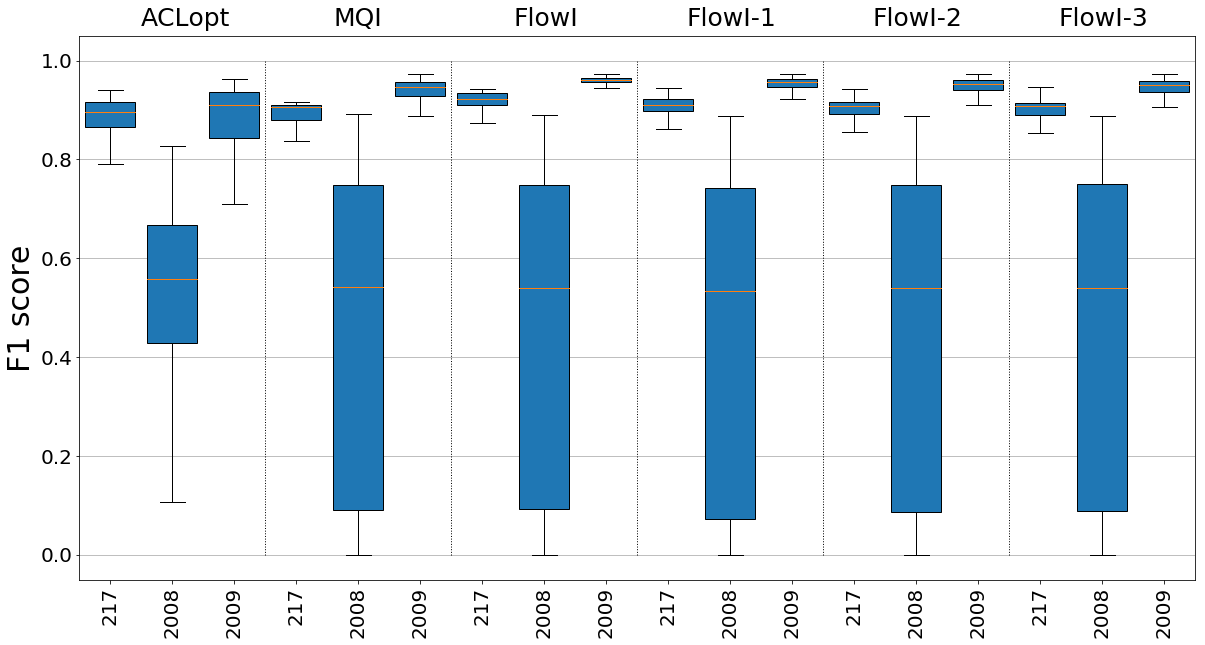

In [15]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_f1.png')

plt.show()

## Generate scatter plot for precision

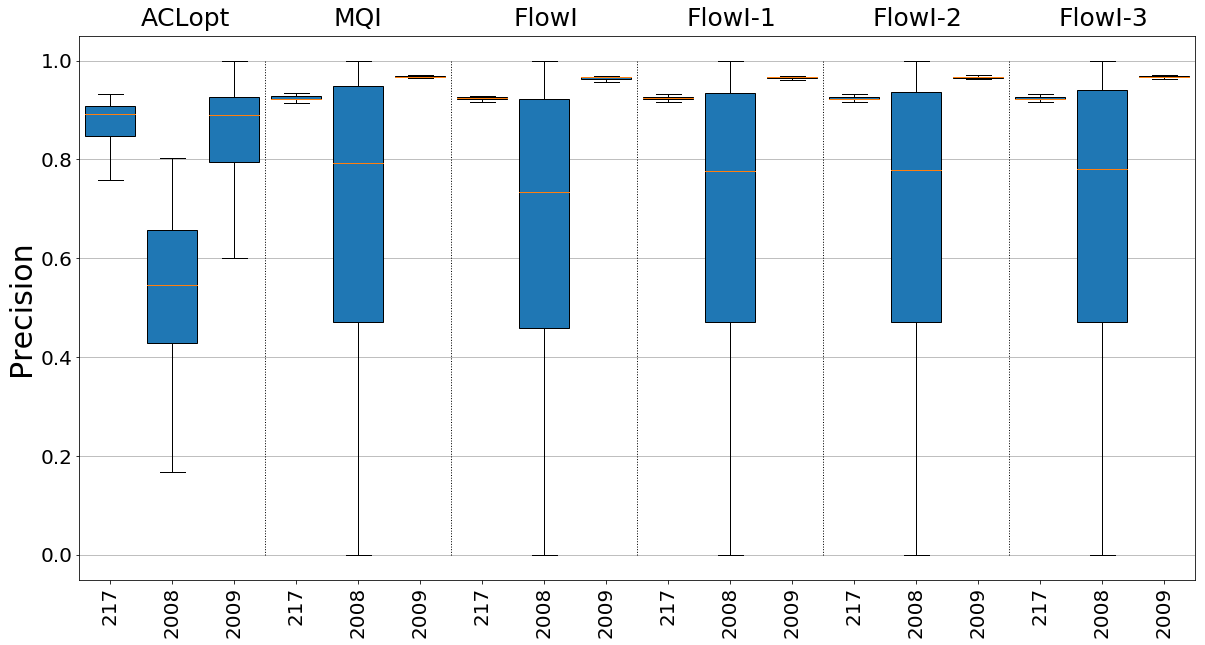

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_precision.png')

plt.show()

## Generate scatter plot for recall

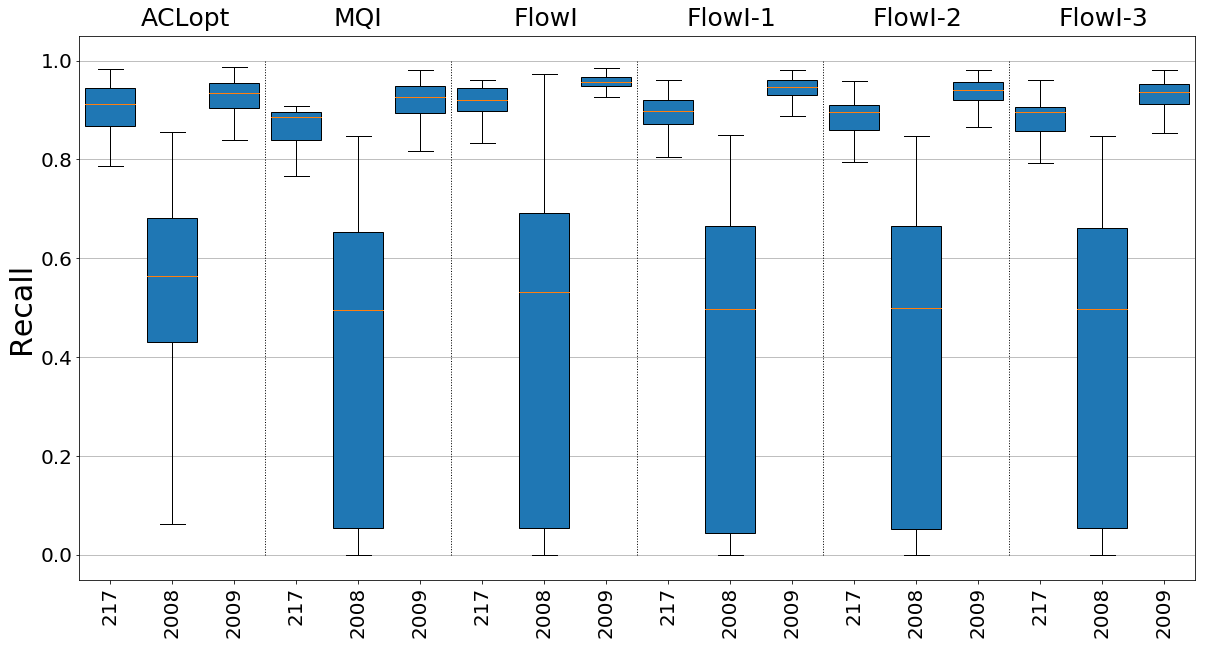

In [17]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_recall.png')

plt.show()

In [18]:
all_data = []
xlabels_ = []

print('Results for ACL')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")
    
print('Results for MQI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        temp_conductance.append(external_cond_acl_flow_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        temp_conductance.append(external_cond_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-1')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-2')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-3')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

Results for ACL
Feature: 217.0 Precision 0.8916593777996156 Recall 0.912911368735976 F1 0.8959754444122436 Cond. 0.20898737413458462
Feature: 2008.0 Precision 0.54637097084163 Recall 0.5649230769230769 F1 0.5573674980026226 Cond. 0.48951426188729097
Feature: 2009.0 Precision 0.8900865295368124 Recall 0.9337832008381093 F1 0.9099451125876146 Cond. 0.2201472109009064
Average precision 0.776038959392686 Average recall 0.8038725488323873 Average F1 0.7877626850008269 Av. Cond. 0.306216282307594
 
Results for MQI
Feature: 217.0 Precision 0.9230114254526531 Recall 0.8857516828721017 F1 0.905361532367752 Cond. 0.1902528267501239
Feature: 2008.0 Precision 0.7937732027396529 Recall 0.49493212669683256 F1 0.540977255048859 Cond. 0.440682880297775
Feature: 2009.0 Precision 0.9678854710775778 Recall 0.9270043754236766 F1 0.9469725579053374 Cond. 0.17671836109515604
Average precision 0.8948900330899613 Average recall 0.769229394997537 Average F1 0.7977704484406495 Av. Cond. 0.26921802271435163
 
Re

In [ ]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=0.8,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='mqi', methodname='MQI', nthreads=24, timeout=1000000, **{"delta": 0})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'mqi' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


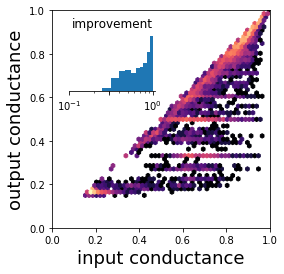

In [21]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='FlowImprove', nthreads=24, timeout=1000000, **{"delta": 0.00001})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'FlowImprove' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


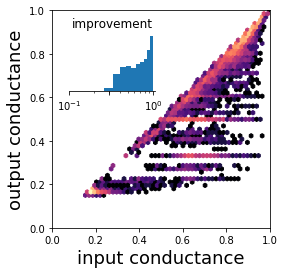

In [22]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.3})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_3' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


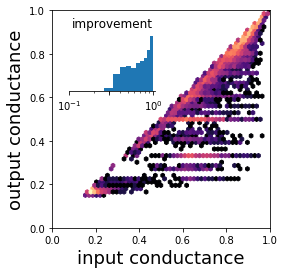

In [23]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.6})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_6' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


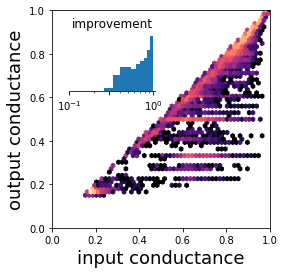

In [24]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.9})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_9' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

In [40]:
cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_JH.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]

cuts_acl_flow = np.load('results/cuts_acl_flow_JH.npy')
cuts_acl_flow = cuts_acl_flow[()]

f1score_acl_flow = np.load('results/f1score_acl_flow_flowImprove_JH.npy')
f1score_acl_flow = f1score_acl_flow[()]

cuts_acl_flow_mqi = np.load('results/cuts_acl_flow_mqi_JH.npy')
cuts_acl_flow_mqi = cuts_acl_flow_mqi[()]

f1score_acl_flow_mqi = np.load('results/f1score_acl_flow_mqi_JH.npy')
f1score_acl_flow_mqi = f1score_acl_flow_mqi[()]

cuts_acl_flow_localflowImprove_parameter1 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_JH.npy')
cuts_acl_flow_localflowImprove_parameter1 = cuts_acl_flow_localflowImprove_parameter1[()]

f1score_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_JH.npy')
f1score_acl_flow_localflowImprove_parameter1 = f1score_acl_flow_localflowImprove_parameter1[()]

cuts_acl_flow_localflowImprove_parameter2 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_JH.npy')
cuts_acl_flow_localflowImprove_parameter2 = cuts_acl_flow_localflowImprove_parameter2[()]

f1score_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_JH.npy')
f1score_acl_flow_localflowImprove_parameter2 = f1score_acl_flow_localflowImprove_parameter2[()]

cuts_acl_flow_localflowImprove_parameter3 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_JH.npy')
cuts_acl_flow_localflowImprove_parameter3 = cuts_acl_flow_localflowImprove_parameter3[()]

f1score_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_JH.npy')
f1score_acl_flow_localflowImprove_parameter3 = f1score_acl_flow_localflowImprove_parameter3[()]

In [42]:
experiment = (2,1417)
ref_set = list(cuts_best_cond_acl[experiment])

In [43]:
# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(ref_set))
print("F1score before improvement:",f1score_best_cond_acl[experiment])

# Conductance and F1score for MQI
output_flow_mqi = list(cuts_acl_flow_mqi[experiment])
print("Conductance MQI:",g.compute_conductance(output_flow_mqi))
print("F1score MQI:",f1score_acl_flow_mqi[experiment])

# Conductance and F1score for FlowImprove
output_flowI = list(cuts_acl_flow[experiment])
print("Conductance FlowImprove:",g.compute_conductance(output_flowI))
print("F1score FlowImprove:",f1score_acl_flow[experiment])

# Conductance and F1score for Local FlowImprove delta_1
output_LocalflowI1 = list(cuts_acl_flow_localflowImprove_parameter1[experiment])
print("Conductance Local FlowImprove 1:",g.compute_conductance(output_LocalflowI1))
print("F1score Local FlowImprove 1:",f1score_acl_flow_localflowImprove_parameter1[experiment])

# Conductance and F1score for Local FlowImprove delta_2
output_LocalflowI2 = list(cuts_acl_flow_localflowImprove_parameter2[experiment])
print("Conductance Local FlowImprove 2:",g.compute_conductance(output_LocalflowI2))
print("F1score Local FlowImprove 2:",f1score_acl_flow_localflowImprove_parameter2[experiment])

# Conductance and F1score for Local FlowImprove delta_3
output_LocalflowI3 = list(cuts_acl_flow_localflowImprove_parameter3[experiment])
print("Conductance Local FlowImprove 3:",g.compute_conductance(output_LocalflowI3))
print("F1score Local FlowImprove 3:",f1score_acl_flow_localflowImprove_parameter3[experiment])

Conductance before improvement: 0.21636058096266955
F1score before improvement: 0.9163246070114629
Conductance MQI: 0.17916517552135863
F1score MQI: 0.9431722871927964
Conductance FlowImprove: 0.16749014947776597
F1score FlowImprove: 0.9599267444747952
Conductance Local FlowImprove 1: 0.16979329235277255
F1score Local FlowImprove 1: 0.9527180467024792
Conductance Local FlowImprove 2: 0.16979329235277255
F1score Local FlowImprove 2: 0.9515400539489368
Conductance Local FlowImprove 3: 0.16979329235277255
F1score Local FlowImprove 3: 0.9487631396739473


In [44]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[ref_set] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in ref_set:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_input.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae7f9e8, at 0x10b5856a0>

In [45]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_flow_mqi] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_flow_mqi:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_mqi.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae7f9e8, at 0x10b5856a0>

In [46]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_flowI] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_flowI:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_flowI.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae7f9e8, at 0x10b5856a0>

In [47]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI1] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI1:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_LocalflowI1.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae7f9e8, at 0x10b5856a0>

In [48]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI2] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI2:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_LocalflowI2.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae7f9e8, at 0x10b5856a0>

In [49]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI3] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI3:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_LocalflowI3.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae7f9e8, at 0x10b5856a0>